In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm import tqdm_notebook as tqdm
import os, sys, copy
import re, glob

In [28]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams["font.size"] = 26

In [2]:
%load_ext autoreload

In [3]:
%autoreload

In [4]:
from chainer import Chain, ChainList, cuda, gradient_check, Function, Link, optimizers, serializers, utils, Variable, datasets, using_config
from chainer import functions as F
from chainer import links as L

import scipy.special as spsp
class Func_erf2(Function): # (erf(x/sqrt(2)))   
    def forward_cpu(self, x):
        sq2 = x[0].dtype.type(np.sqrt(2.0))
        self.y = utils.force_array(spsp.erf(x[0]/sq2))
        return self.y,
    def backward_cpu(self, x, gy):
        sq2pi = x[0].dtype.type(np.sqrt(2.0/np.pi))
        two = x[0].dtype.type(2.0)
        return utils.force_array(gy[0]*sq2pi*np.exp(-x[0]*x[0]/two)),
def func_erf2(x):
    return Func_erf2()(x)

def is_integer_type(typ):
    try:
        xp = cuda.cupy
        return typ in [int, np.int, np.int8, np.int16, np.int32, np.int64,
                np.uint, np.uint8, np.uint16, np.uint32, np.uint64,
                xp.int8, xp.int16, xp.int32, xp.int64,
                xp.uint8, xp.uint16, xp.uint32, xp.uint64,]
    except AttributeError:
        return typ in [int, np.int, np.int8, np.int16, np.int32, np.int64,
                np.uint, np.uint8, np.uint16, np.uint32, np.uint64]



class MLP(ChainList):
    def __init__(self, ls, nobias, act, opt):
        self.ls = ls
        self.l = []
        for i in range(len(ls)-1):
            self.l.append(L.Linear(ls[i], ls[i+1], nobias=nobias))
        super(MLP, self).__init__(*self.l)
        self.act = act
        self.opt = opt
        if self.opt is not None: self.opt.setup(self)
        self.lossfrac = np.zeros(2)
        self.accfrac = np.zeros(2)
    def __call__(self, x, mode='train'): # Args: Variable, Returns: Variable
        with using_config('train', mode=='train'):
            for i in range(len(self.l)):
                x = self.l[i](x)
                if (i+1<len(self.l)): x = self.act(x)
        return x
    def update(self, x, t, mode='train'): # Args: Variable, Returns: Variable
        bs = x.shape[0]
        y = self(x, mode=mode)
        if is_integer_type(t.data.dtype):
            if 1: # classification (softmax_cross_entropy)
                loss = F.softmax_cross_entropy(y, t)
                acc = np.count_nonzero(np.argmax(y.data,axis=1)==t.data)
            elif 0: # binary classification (sigmoid_cross_entropy)
                loss = F.sigmoid_cross_entropy(y, t) # y and t has same dimension
                acc = np.count_nonzero((y.data>0).astype(np.int32)==t.data)
            else:
                raise ValueError
        else:
            # regression (squared)
            loss = 0.5 * F.sum((y - t)**2) / bs
            acc = 0

        # loss should be divided by bs (mini-batch size) 
        if mode=='train':
            self.cleargrads()
            loss.grad = np.ones(loss.shape, dtype=np.float32)
            loss.backward()
            self.opt.update()
        elif mode=='test':
            pass
        else:
            raise ValueError
        self.lossfrac += np.array([np.sum(loss.data) * bs, bs])
        self.accfrac += np.array([acc, bs])
        return loss
    def aveloss(self, clear=False):
        ret = self.lossfrac[0]/self.lossfrac[1]
        if clear: self.lossfrac = np.zeros(2)
        return ret
    def aveacc(self, clear=False):
        ret = (0.+self.accfrac[0])/self.accfrac[1]
        if clear: self.accfrac = np.zeros(2)
        return ret
    def W(self, idx):
        return self.l[idx].W.data

In [5]:
def retain_random_state(func):
    def wrapper(*args, **kwargs):
        random_state = np.random.get_state()
        func(*args, **kwargs)
        np.random.set_state(random_state)
    return wrapper

In [6]:
def average(ary, bin_width):
    return np.array([np.mean(ary[i:i+bin_width]) for i in range(0,len(ary),bin_width)])

In [7]:
def overlap(v1, v2):
    return np.dot(v1, v2)/np.linalg.norm(v1)/np.linalg.norm(v2)

In [8]:
def get_mnist_lambdas():
    train, test = datasets.get_mnist()
    ary = np.array([data[0] for data in train]).astype(np.float64) # (60000, 784)
    return np.sort(np.linalg.svd(ary, compute_uv=False) ** 2) / ary.shape[0]
mnist_lambdas = get_mnist_lambdas()

In [9]:
def name2idx(s):
    if s[:6]=='setosa': return 0
    elif s[:10]=='versicolor': return 1
    else: return 2
def get_iris_data():
    with open('iris.csv', 'r') as f:
        lines = f.readlines()
    data = []
    for line in lines[1:]:
        datum = line.split(',')
        data.append((np.array(list(map(float, datum[:4]))), name2idx(datum[4])))
    return data
def get_iris_lambdas():
    train = get_iris_data()
    ary = np.array([data[0] for data in train]).astype(np.float64) # (150, 4)
    return np.sort(np.linalg.svd(ary, compute_uv=False) ** 2) / ary.shape[0]
iris_lambdas = get_iris_lambdas()

In [10]:
def show_lambda_statistics(lambdas):
    print('lambdas:', lambdas[:5], '...', lambdas[-5:])
    print('<lambda>', np.mean(lambdas))
    print('<lambda**2>', np.mean(lambdas**2))
    print('<lambda**4>', np.mean(lambdas**4))
    print('<lambda**2>/<lambda>', np.mean(lambdas**2)/np.mean(lambdas))
    print('sqrt(<lambda**4>/<lambda**2>)', np.sqrt(np.mean(lambdas**4)/np.mean(lambdas**2)))
    print('overlap of lambdas and lambdas**2:  ', overlap(lambdas, lambdas**2))


In [11]:
def logspace_with_moment(n, m1, m2):
    # Returns [a, ar, ..., ar^(n-1)] such that its first and second moment are equal to m1 and m2, respectively
    lo_r = 1
    hi_r = 20
    eps = 1e-8
    for i in range(1000):
        r = (lo_r + hi_r) / 2
        a = m1 * n * (r - 1) / (r**n - 1) if r!=1 else m1
        m2_temp = a * a * (r**(2*n) - 1) / (r**2 - 1) / n if r!=1 else a * a
        if m2_temp > m2 + eps:
            hi_r = r
        elif m2_temp < m2 - eps:
            lo_r = r
        else:
            break
    if i==999:
        raise ValueError('converge failed!')
    return np.array([a * r**i for i in range(n)])

In [12]:
def linspace_with_moment(n, m1, m2):
    # [a, .., b]
    ret = np.linspace(-1, 1, n)
    return ret / np.std(ret) * np.sqrt(m2 - m1*m1) + m1

In [13]:
def one_nonzero_with_moment(n, m1, m2):
    # [0, ..., 0, a, ..., a (c times)]
    # m1 = a * c / n
    # m2 = a^2 * c / n
    a = m2 / m1
    c = max(0, min(n, int(m1 * n / a + 0.5)))
    return np.array([0.0] * (n-c) + [a] * c)

In [14]:
def two_nonzero_with_moment(n, m1, m2, fixed_p1=0.5, fixed_p2=0.5):
    # [0, ..., 0, l1, ..., l1 (fraction: p1), l2, ..., l2 (fraction: p2)]
    # m1 = l1 * p1 + l2 * p2
    # m2 = l1**2 * p1 + l2**2 * p2 
    pass


In [15]:
def learn(N, nb_iter, lambdas, lr, act=func_erf2, from_scratch=True, rslt=None, verbose=True):
    '''
    SGD learning of two-layer erf2 soft-committee machines
    
    Args:
        from_scratch (bool):
            learning from scratch, or continued learning
            
        lr (float)
            learning rate. (passed to optimizers.SGD as the argument `lr`)
            (specify 1/N typically)
    '''
    lambdas = np.sort(lambdas)
    if lambdas[0] < 0:
        print('WARNING!! minimum lambda < 0 !!')
    
    bs = 1000
    if from_scratch: # learning from scratch
        # N = 100
        mdl = MLP(ls=[N,2,1], nobias=True, act=act, opt=optimizers.SGD(lr=lr))
        mdl_t = MLP(ls=[N,2,1], nobias=True, act=act, opt=None)
        mdl.l[1].W.data = np.array([[1, 1]], dtype=np.float32)
        mdl_t.l[1].W.data = np.array([[1, 1]], dtype=np.float32)
        mdl0 = copy.deepcopy(mdl)    
        if verbose:
            show_lambda_statistics(lambdas)
        cov = np.diag(lambdas)
        cov_pow = {i: np.diag([l**i for l in lambdas]) for i in range(-10, 11)}
        Ls = np.array([np.nan])
        Qs = { i : np.zeros([0,2,2]) for i in range(-10,11) }
        Rs = { i : np.zeros([0,2,2]) for i in range(-10,11) }
        T = { i : np.dot(np.dot(mdl_t.W(0), cov_pow[i],), mdl_t.W(0).T) for i in range(-10,11)}
    else: # continued learning
        mdl, mdl_t, mdl0, Ls, Qs, Rs, T = rslt['mdl'], rslt['mdl_t'], rslt['mdl0'], rslt['Ls'], rslt['Qs'], rslt['Rs'], rslt['T']
        cov = np.diag(lambdas)
        cov_pow = {i: np.diag([l**i for l in lambdas]) for i in range(-10, 11)}
        

    # number of iterations
    # nb_iter = 100 * N

    # allocate memory, filled with nan
    index_QR = Qs[-10].shape[0]
    index_L = Ls.shape[0]
    for i in range(-10,11):
        Qs[i] = np.r_[Qs[i], np.nan+np.zeros([nb_iter,2,2])]
        Rs[i] = np.r_[Rs[i], np.nan+np.zeros([nb_iter,2,2])]
    Ls = np.r_[Ls, np.nan+np.zeros([nb_iter])]

    
    for it in (tqdm(range(nb_iter)) if verbose else range(nb_iter)):
        for i in range(-10, 11):
            current_Q = np.dot(np.dot(mdl.W(0), cov_pow[i],), mdl.W(0).T)
            current_R = np.dot(np.dot(mdl.W(0), cov_pow[i],), mdl_t.W(0).T)
            # Qs[i] = np.r_[Qs[i], [current_Q]]
            # Rs[i] = np.r_[Rs[i], [current_R]]
            Qs[i][index_QR+it,:,:] = current_Q
            Rs[i][index_QR+it,:,:] = current_R

        xi = Variable(np.random.multivariate_normal(np.zeros(N), cov, [bs]).astype(np.float32))
        t = mdl_t(xi)
        lo = mdl.update(xi, t, mode='train')
        # Ls = np.r_[Ls, lo.data]
        Ls[index_L+it] = lo.data

        # since it is soft-committee machine
        mdl.l[1].W.data = np.array([[1, 1]], dtype=np.float32)

        if it == nb_iter//2:
            mdl_halfway = copy.deepcopy(mdl) # model snapshots when half of learning finished (for debugging macro-system)

    return {'Qs':Qs, 'Rs':Rs, 'T':T, 'Ls':Ls, 'mdl0':mdl0, 'mdl':mdl, 'mdl_halfway':mdl_halfway, 'mdl_t':mdl_t}

In [25]:
def plot_micro_dynamics(N, till, Qs, Rs, Ls, drawstep=1):
    # drawstep = 1
    # till = 200 * N
    plt.plot(np.arange(len(Ls))[:till:drawstep], Ls[:till:drawstep], color='k')
    for power in range(1, 2):
        for ij in (0,0),(0,1),(1,1):
            i,j = ij
            plt.plot(np.arange(len(Qs[power]))[:till:drawstep], Qs[power][:till:drawstep,i,j], color='b')
        for ij in (0,0),(0,1),(1,0),(1,1):
            i,j = ij
            plt.plot(np.arange(len(Rs[power]))[:till:drawstep], Rs[power][:till:drawstep,i,j], color='g')
    plt.yscale('log')
    plt.xlabel('Iteration')

In [16]:
# for calculating order parameter system
import order_parameter_dynamics as opd

In [17]:
def calc_opd(N, nb_iter, lambdas, eta, act='erf', mdl=None, mdl_t=None, ignore_etasq=[False, True], slowing=1.0, verbose=True, goal_loss=None):

    if mdl is not None:
        tmp_mdl = mdl
    else:
        tmp_mdl = MLP(ls=[N,2,1], nobias=True, act=func_erf2, opt=optimizers.SGD(lr=eta/N))    
        tmp_mdl.l[1].W.data = np.array([[1, 1]], dtype=np.float32)
    
    if mdl_t is not None:
        tmp_mdl_t = mdl_t
    else:
        tmp_mdl_t = MLP(ls=[N,2,1], nobias=True, act=func_erf2, opt=None)
        tmp_mdl_t.l[1].W.data = np.array([[1, 1]], dtype=np.float32)

    ncov = np.diag(lambdas)
    # ncov = np.diag([1] * N)

    _ = np.r_[tmp_mdl.W(0), tmp_mdl_t.W(0)]
    nQRT = np.dot(np.dot(_, ncov), _.T)
    print('nQRT:', nQRT)
    _ = np.c_[tmp_mdl.W(1), tmp_mdl_t.W(1)]
    nABC = np.dot(_.T, _)
    print('nABC:', nABC)

    ncovncov = np.dot(ncov, ncov)
    nT4 = np.dot(np.dot(tmp_mdl_t.W(0), np.dot(ncovncov, ncovncov)), tmp_mdl_t.W(0).T)
    nT2 = np.dot(np.dot(tmp_mdl_t.W(0), ncovncov), tmp_mdl_t.W(0).T)
    nT1 = np.dot(np.dot(tmp_mdl_t.W(0), ncov), tmp_mdl_t.W(0).T)
    print('sqrt(nT4/nT2): ', np.sqrt(nT4/nT2))
    print('nT2/nT1: ', nT2/nT1)
    QRTcoef = np.array([np.sqrt(nT4/nT2)[0,0], nT2[0,0]])

    QRTcoef *= slowing
    if slowing != 1: print('!! slowing:', slowing)

    print('QRTcoef: ', QRTcoef)

    op = opd.opd_inf_KM_inf(nQRT, nABC, K=2, M=2, eta=eta, act=act, ignore_etasq=ignore_etasq, QRTcoef=QRTcoef, ABCcoef=[0]) # ABCcoef=[0] for  soft-committee machine
    # nb_iter = 1000
    print('nb_iter:', nb_iter)

    opQRT = np.zeros([nb_iter+1,4,4]) + np.nan
    # opABC = np.zeros([nb_iter+1,4,4]) + np.nan
    opL = np.zeros([nb_iter+1]) + np.nan
    opQRT[0,:,:] = op.QRT.copy()
    opL[0] = op.eps()

    for it in tqdm(range(0,nb_iter)):
        op.update()
        opQRT[1+it,:,:] = op.QRT.copy()
        opL[1+it] = op.eps()
        if goal_loss is not None and opL[1+it] < goal_loss: # finished when the loss achieved goal_loss
            opQRT = opQRT[:1+it+1,:,:]
            opL = opL[:1+it+1]
            break
        
    return {'opQRT':opQRT, 'opL':opL, 'mdl0':tmp_mdl, 'mdl_t':tmp_mdl_t}

In [18]:
def calc_opd_highorder(N, nb_iter, lambdas, eta, act='erf', mdl=None, mdl_t=None, ignore_etasq=[False, True], substep=1, slowing=None, verbose=True, goal_loss=None):

    assert slowing is None, 'specifying `slowing` is deprecated. Instead specify `substep`.'
    
    if mdl is not None:
        tmp_mdl = mdl
    else:
        tmp_mdl = MLP(ls=[N,2,1], nobias=True, act=func_erf2, opt=optimizers.SGD(lr=eta/N))    
        tmp_mdl.l[1].W.data = np.array([[1, 1]], dtype=np.float32)
    
    if mdl_t is not None:
        tmp_mdl_t = mdl_t
    else:
        tmp_mdl_t = MLP(ls=[N,2,1], nobias=True, act=func_erf2, opt=None)
        tmp_mdl_t.l[1].W.data = np.array([[1, 1]], dtype=np.float32)

    ncov = np.diag(lambdas)
    # ncov = np.diag([1] * N)
    
    nonzero_distinct_lambdas = np.unique(lambdas[np.nonzero(lambdas)])  # non-zero distinct eigenvalues
    deg = len(nonzero_distinct_lambdas) # number of them

    nQRT = np.zeros([deg, 4, 4]).astype(np.float)
    weight_mat = np.r_[tmp_mdl.W(0), tmp_mdl_t.W(0)]
    for e in range(deg):
        nQRT[e] = np.dot(np.dot( weight_mat, ncov ** (e+1)),  weight_mat.T)
    print('nQRT:', nQRT)
    _ = np.c_[tmp_mdl.W(1), tmp_mdl_t.W(1)]
    nABC = np.dot(_.T, _)
    print('nABC:', nABC)
    
    ncovncov = np.dot(ncov, ncov)
    nT4 = np.dot(np.dot(tmp_mdl_t.W(0), np.dot(ncovncov, ncovncov)), tmp_mdl_t.W(0).T)
    nT2 = np.dot(np.dot(tmp_mdl_t.W(0), ncovncov), tmp_mdl_t.W(0).T)
    nT1 = np.dot(np.dot(tmp_mdl_t.W(0), ncov), tmp_mdl_t.W(0).T)
    print('sqrt(nT4/nT2): ', np.sqrt(nT4/nT2))
    print('nT2/nT1: ', nT2/nT1)

    QRTcoef = np.array([1.0, 1.0])
    op = opd.opd_inf_KM_inf_highorder(lambdas, nQRT, nABC, K=2, M=2, eta=eta, act=act, QRTcoef=QRTcoef, ABCcoef=[0], ignore_etasq=ignore_etasq, substep=substep)  # ABCcoef=[0] for  soft-committee machine
    # nb_iter = 1000
    print('nb_iter:', nb_iter)

    opQRT = np.zeros([nb_iter+1, deg, 4,4]) + np.nan
    opL = np.zeros([nb_iter+1]) + np.nan
    opQRT[0] = op.QRT.copy()
    opL[0] = op.eps()

    for it in tqdm(range(0,nb_iter)):
        op.update()
        opQRT[1+it] = op.QRT.copy()
        opL[1+it] = op.eps()
        if goal_loss is not None and opL[1+it] < goal_loss: # finished when the loss achieved goal_loss
            opQRT = opQRT[:1+it+1]
            opL = opL[:1+it+1]
            break
        
    return {'opQRT':opQRT, 'opL':opL, 'mdl0':tmp_mdl, 'mdl_t':tmp_mdl_t}

In [19]:
def plot_macro_dynamics(opL, opQRT, N=1, till=None, slowing=1.0):
    if till is None:
        till = len(opL)
    lines = []
    
    lines.append(plt.plot(np.arange(len(opL))[:till]*N*slowing, opQRT[:till,0,0], color='b')[0])
    plt.plot(np.arange(len(opL))[:till]*N*slowing, opQRT[:till,0,1], color='b')
    plt.plot(np.arange(len(opL))[:till]*N*slowing, opQRT[:till,1,1], color='b')
    plt.plot(np.arange(len(opL))[:till]*N*slowing, opQRT[:till,0,2], color='g')
    
    lines.append(plt.plot(np.arange(len(opL))[:till]*N*slowing, opQRT[:till,0,3], color='g')[0])
    plt.plot(np.arange(len(opL))[:till]*N*slowing, opQRT[:till,1,2], color='g')
    plt.plot(np.arange(len(opL))[:till]*N*slowing, opQRT[:till,1,3], color='g')
    
    lines.append(plt.plot(np.arange(len(opL))[:till]*N*slowing, opL[:till], color='k')[0])
    plt.yscale('log')
    
    plt.legend(lines, ['$Q_{ij}$', '$R_{in}$', '$\\varepsilon_g$'], loc='best', fontsize=20)

In [20]:
N = 100

## (End of preparation)

In [17]:
nb_iter = 10 * N

# lambdas = np.r_[iris_lambdas, np.array([iris_lambdas[-1]]*(N-4)),] # exhibits short plateau
# lambdas = mnist_lambdas[0:700:7] # no plateau
# lambdas = mnist_lambdas[0:700:7] * 25 # ambiguous!
# lambdas = mnist_lambdas[0:700:7] * 250 # ambiguous!
# lambdas = np.linspace(0.14, 1.86, N) # plateau shows up
# lambdas = mnist_lambdas[0:700:7] * 150 # no plateau, but it shows up on order-parameter simulation (without higher-order)
# lambdas = np.sort(np.tile(iris_lambdas, N//4)) # no plateau (or very short plateau?)
# lambdas = np.array([0.3] * (N*4//10) + [1.2] * (N*6//10)) # plateau shows up (３０N~60N steps)
# lambdas = np.array([0.5+2.0*i/N for i in range(N)]) # short plateau shows up (20N~30N steps)
# lambdas = np.ones(N) # plateau shows up 
# lambdas = logspace_with_moment(100, 1, 1.25) # shows up
# lambdas = logspace_with_moment(100, 0.007512, 0.0002054) # no plateau at least till 1000N steps
# lambdas = np.array([0.0] * 90 + [10.0] * 10) # shows up
# lambdas = one_nonzero_with_moment(100, 0.007512, 0.0002054)
# lambdas = one_nonzero_with_moment(100, 1.88, 12.83)
# lambdas = np.array([0.0]*73 + [1.0]*27)
lambdas = np.array([0.3]*50 + [1.7]*50)

from_scratch = True # learning from scratch

rslt = learn(N, nb_iter, lambdas, from_scratch=from_scratch, rslt=None)
Qs, Rs, T, Ls, mdl0, mdl_halfway = rslt['Qs'], rslt['Rs'], rslt['T'], rslt['Ls'], rslt['mdl0'], rslt['mdl_halfway']

lambdas: [0.3 0.3 0.3 0.3 0.3] ... [1.7 1.7 1.7 1.7 1.7]
<lambda> 1.0
<lambda**2> 1.4899999999999993
<lambda**4> 4.1800999999999995
<lambda**2>/<lambda> 1.4899999999999993
sqrt(<lambda**4>/<lambda**2>) 1.6749436532644133
overlap of lambdas and lambdas**2:   0.9897157540640419



/Users/yoshidayuuki/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


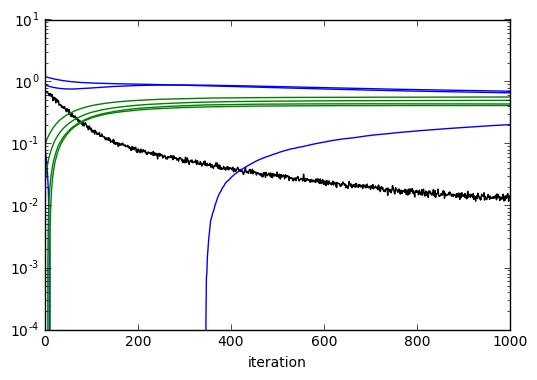

In [19]:
plot_micro_dynamics(N, 100*N, Qs, Rs, Ls)
plt.show()

In [18]:
def plot_frac21_dynamics(N, till, Qs, Rs, drawstep=1):
    # drawstep = 1
    # till = 50 * N
    for ij in (0,0),(0,1),(1,1):
        i,j = ij
        plt.plot(np.arange(len(Qs[1]))[:till:drawstep], Qs[2][:till:drawstep,i,j]/Qs[1][:till:drawstep,i,j], color='b')
    for ij in (0,0),(0,1),(1,0),(1,1):
        i,j = ij
        plt.plot(np.arange(len(Rs[1]))[:till:drawstep], Rs[2][:till:drawstep,i,j]/Rs[1][:till:drawstep,i,j], color='g')
    plt.yscale('log')
    plt.xlabel('iteration')

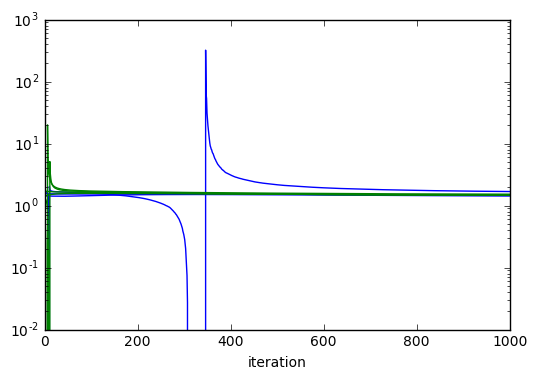

In [21]:
plot_frac21_dynamics(N, 300*N, Qs, Rs)
plt.show()

In [84]:
# calculate and save order parameter dynamics in cases with various eigenvalue distributions
for lam2 in [0.1, 0.2, 0.3, 0.5, 0.7, 1.0]:
    for p1 in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
        print('lam2==',lam2, ',p1==',p1)
        N = 100
        nb_iter = 200 * N
        n1 = int(N * p1)
        lambdas = np.array([lam2] * (N-n1) + [1.0] * n1)
        from_scratch = True
        rslt = learn(N, nb_iter, lambdas, from_scratch, verbose=False)
        Qs, Rs, T, Ls, mdl0 = rslt['Qs'], rslt['Rs'], rslt['T'], rslt['Ls'], rslt['mdl0']
        
        path = './SCM_erf2_ST_N100_twoLambda/'
        np.savez(path + 'p1={}_lam2={}.npz'.format(p1,lam2), Qs=Qs, Rs=Rs, T=T, Ls=Ls, mdl0=mdl0)
        plot_micro_dynamics(N, nb_iter, Qs, Rs, Ls)
        plt.title('p1={}, lam2={}'.format(p1,lam2))
        plt.savefig(path + 'micro_dynamics_p1={}_lam2={}.png'.format(p1,lam2))
        plt.close()
        plot_frac21_dynamics(N, nb_iter, Qs, Rs)
        plt.title('p1={}, lam2={}'.format(p1,lam2))
        plt.savefig(path + 'frac21_dynamics_p1={}_lam2={}.png'.format(p1,lam2))
        plt.close()

lam2== 0.1 ,p1== 0


/Users/yoshidayuuki/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


lam2== 0.1 ,p1== 0.1
lam2== 0.1 ,p1== 0.2
lam2== 0.1 ,p1== 0.3
lam2== 0.1 ,p1== 0.4
lam2== 0.1 ,p1== 0.5
lam2== 0.1 ,p1== 0.6
lam2== 0.1 ,p1== 0.7
lam2== 0.1 ,p1== 0.8
lam2== 0.1 ,p1== 0.9
lam2== 0.1 ,p1== 1.0
lam2== 0.2 ,p1== 0
lam2== 0.2 ,p1== 0.1
lam2== 0.2 ,p1== 0.2
lam2== 0.2 ,p1== 0.3
lam2== 0.2 ,p1== 0.4
lam2== 0.2 ,p1== 0.5
lam2== 0.2 ,p1== 0.6
lam2== 0.2 ,p1== 0.7
lam2== 0.2 ,p1== 0.8
lam2== 0.2 ,p1== 0.9
lam2== 0.2 ,p1== 1.0
lam2== 0.3 ,p1== 0
lam2== 0.3 ,p1== 0.1
lam2== 0.3 ,p1== 0.2
lam2== 0.3 ,p1== 0.3
lam2== 0.3 ,p1== 0.4
lam2== 0.3 ,p1== 0.5
lam2== 0.3 ,p1== 0.6
lam2== 0.3 ,p1== 0.7
lam2== 0.3 ,p1== 0.8
lam2== 0.3 ,p1== 0.9
lam2== 0.3 ,p1== 1.0
lam2== 0.5 ,p1== 0
lam2== 0.5 ,p1== 0.1
lam2== 0.5 ,p1== 0.2
lam2== 0.5 ,p1== 0.3
lam2== 0.5 ,p1== 0.4
lam2== 0.5 ,p1== 0.5
lam2== 0.5 ,p1== 0.6
lam2== 0.5 ,p1== 0.7
lam2== 0.5 ,p1== 0.8
lam2== 0.5 ,p1== 0.9
lam2== 0.5 ,p1== 1.0
lam2== 0.7 ,p1== 0
lam2== 0.7 ,p1== 0.1
lam2== 0.7 ,p1== 0.2
lam2== 0.7 ,p1== 0.3
lam2== 0.7 ,p1== 0.4


In [93]:
# calculate and save order parameter dynamics in cases with various eigenvalue distributions    ver2
for num in [2,3,4,5,6,8,10,20,30,60,120]:
    N = 120
    nb_iter = 200 * N
    # lambdas として，平均1,標準偏差0.5なnum項の等差数列（をN項に水増ししたもの）を用意する．
    lambda_kind = np.arange(num)
    lambda_kind = (lambda_kind - np.mean(lambda_kind)) / np.std(lambda_kind) * 0.5 + 1
    lambdas = np.sort(lambda_kind.tolist() * (N//num))
    assert(lambdas[0] >= 0)
    from_scratch = True
    rslt = learn(N, nb_iter, lambdas, from_scratch, verbose=True)
    Qs, Rs, T, Ls, mdl0 = rslt['Qs'], rslt['Rs'], rslt['T'], rslt['Ls'], rslt['mdl0']

    path = './SCM_erf2_ST_N120_variousNumberOfLambda/'
    np.savez(path + 'num={}.npz'.format(num), Qs=Qs, Rs=Rs, T=T, Ls=Ls, mdl0=mdl0)
    plot_micro_dynamics(N, nb_iter, Qs, Rs, Ls)
    plt.title('num={}'.format(num))
    plt.savefig(path + 'micro_dynamics_num={}.png'.format(num))
    plt.close()
    plot_frac21_dynamics(N, nb_iter, Qs, Rs)
    plt.title('num={}'.format(num))
    plt.savefig(path + 'frac21_dynamics_num={}.png'.format(num))
    plt.close()

lambdas: [0.14116165 0.15559591 0.17003017 0.18446443 0.19889868] ... [1.80110132 1.81553557 1.82996983 1.84440409 1.85883835]
<lambda> 1.0
<lambda**2> 1.25
<lambda**4> 2.612489582609903
<lambda**2>/<lambda> 1.25
sqrt(<lambda**4>/<lambda**2>) 1.4456803471334605
overlap of lambdas and lambdas**2:   0.968402180174866



/Users/yoshidayuuki/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


lambdas: [0.14116165 0.15559591 0.17003017 0.18446443 0.19889868] ... [1.80110132 1.81553557 1.82996983 1.84440409 1.85883835]
<lambda> 1.0
<lambda**2> 1.25
<lambda**4> 2.612489582609903
<lambda**2>/<lambda> 1.25
sqrt(<lambda**4>/<lambda**2>) 1.4456803471334605
overlap of lambdas and lambdas**2:   0.968402180174866

lambdas: [0.14116165 0.15559591 0.17003017 0.18446443 0.19889868] ... [1.80110132 1.81553557 1.82996983 1.84440409 1.85883835]
<lambda> 1.0
<lambda**2> 1.25
<lambda**4> 2.612489582609903
<lambda**2>/<lambda> 1.25
sqrt(<lambda**4>/<lambda**2>) 1.4456803471334605
overlap of lambdas and lambdas**2:   0.968402180174866

lambdas: [0.14116165 0.15559591 0.17003017 0.18446443 0.19889868] ... [1.80110132 1.81553557 1.82996983 1.84440409 1.85883835]
<lambda> 1.0
<lambda**2> 1.25
<lambda**4> 2.612489582609903
<lambda**2>/<lambda> 1.25
sqrt(<lambda**4>/<lambda**2>) 1.4456803471334605
overlap of lambdas and lambdas**2:   0.968402180174866

lambdas: [0.14116165 0.15559591 0.17003017 0.1

In [39]:
# calculate and save order parameter dynamics in cases with various eigenvalue distributions    ver3
for m2 in [0.27, 0.5, 1, 2, 4, 8]:
    print('m2==', m2)
    N = 100
    nb_iter = 200 * N

    m1 = 0.27
    lambdas = one_nonzero_with_moment(N, m1, m2)
    
    from_scratch = True
    rslt = learn(N, nb_iter, lambdas, from_scratch=from_scratch, verbose=True)
    Qs, Rs, T, Ls, mdl0 = rslt['Qs'], rslt['Rs'], rslt['T'], rslt['Ls'], rslt['mdl0']

    path = './SCM_erf2_ST_N100_m1fix/'
    np.savez(path + 'm2={}.npz'.format(m2), Qs=Qs, Rs=Rs, T=T, Ls=Ls, mdl0=mdl0)
    plot_micro_dynamics(N, nb_iter, Qs, Rs, Ls)
    plt.title('m2={}'.format(m2))
    plt.savefig(path + 'micro_dynamics_m2={}.png'.format(m2))
    plt.close()
    plot_frac21_dynamics(N, nb_iter, Qs, Rs)
    plt.title('m2={}'.format(m2))
    plt.savefig(path + 'frac21_dynamics_m2={}.png'.format(m2))
    plt.close()

m2== 0.27
1.0 27
m2== 0.5
1.8518518518518516 15
m2== 1
3.7037037037037033 7
m2== 2
7.4074074074074066 4
m2== 4
14.814814814814813 2
m2== 8
29.629629629629626 1


In [24]:
Qs[1][-1]

array([[12.3927269 ,  3.94581281],
       [ 3.94581281, 16.25608844]])

In [25]:
T[1], T[0] # 「真の解が特異領域にある」わけでもないようだ（T[1]は退化していない．）

(array([[14.02843255,  3.98379546],
        [ 3.98379546, 15.09568275]]), array([[0.83787804, 0.03382554],
        [0.03382554, 0.83948941]]))

In [26]:
'''
opd_inf_KM_inf での計算．1次のオーダパラメータのみ考慮．
'''
nb_iter = 100
eta = 1.0
# lambdas = 0.5 * np.ones(N)
# nrslt = calc_opd(N, nb_iter, lambdas, eta)
nrslt = calc_opd(N, nb_iter, lambdas, eta, mdl=rslt['mdl0'], mdl_t=rslt['mdl_t'])
opL, opQRT = nrslt['opL'], nrslt['opQRT']

nQRT: [[ 0.87991846  0.082498    0.0965595  -0.04670058]
 [ 0.082498    1.19979956 -0.02520567  0.02147616]
 [ 0.0965595  -0.02520567  0.95605896  0.13379069]
 [-0.04670058  0.02147616  0.13379069  0.84317546]]
nABC: [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
sqrt(nT4/nT2):  [[1.66870946 1.6956709 ]
 [1.6956709  1.66288354]]
nT2/nT1:  [[1.4459702  1.65934548]
 [1.65934548 1.40724919]]
QRTcoef:  [1.66870946 1.38243276]
nb_iter: 100



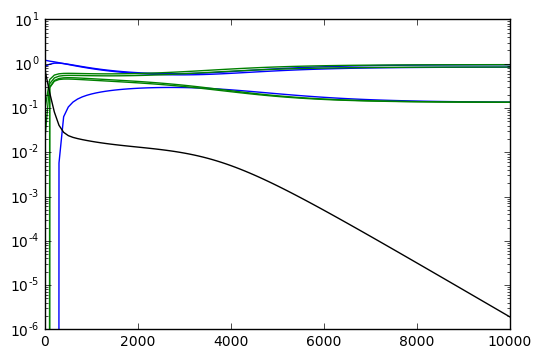

In [27]:
plot_macro_dynamics(opL, opQRT, N=N)
plt.show()

In [28]:
'''
opd_inf_KM_inf_highorder での計算．高次のオーダパラメータまで考慮．
'''
nb_iter = 100
eta = 1.0
substep = 10
# nrslt = calc_opd_highorder(N, nb_iter, np.array([0.5]*50+[1.5]*50), eta, ignore_etasq=[True, True])
nrslt = calc_opd_highorder(N, nb_iter, lambdas, eta, mdl=rslt['mdl0'], mdl_t=rslt['mdl_t'], ignore_etasq=[True, True], substep=substep)
# ignore_etasqをオンにしていることに注意（つまり学習係数が十分小さい状況）
# オフにすると，ミクロとマクロが一致しない・・・（これはそもそも理論の近似が不十分かもしれない．）
opL, opQRT = nrslt['opL'], nrslt['opQRT']

nQRT: [[[ 0.87991846  0.082498    0.0965595  -0.04670058]
  [ 0.082498    1.19979956 -0.02520567  0.02147616]
  [ 0.0965595  -0.02520567  0.95605896  0.13379069]
  [-0.04670058  0.02147616  0.13379069  0.84317546]]

 [[ 1.262167    0.13395987  0.13581514 -0.06229739]
  [ 0.13395987  1.85938525 -0.01913075  0.03733848]
  [ 0.13581514 -0.01913075  1.38243276  0.22200498]
  [-0.06229739  0.03733848  0.22200498  1.18655798]]]
nABC: [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
sqrt(nT4/nT2):  [[1.66870946 1.6956709 ]
 [1.6956709  1.66288354]]
nT2/nT1:  [[1.4459702  1.65934548]
 [1.65934548 1.40724919]]
poly deg: 2
nb_iter: 100



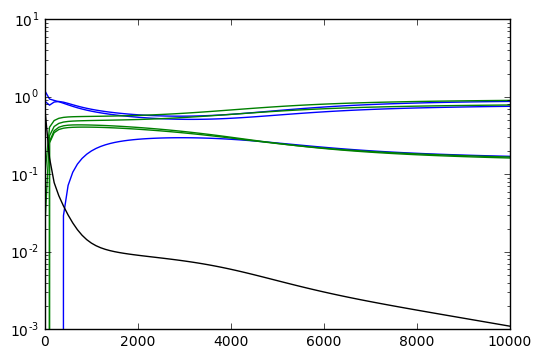

In [29]:
plot_macro_dynamics(opL, opQRT[:,0,:,:], N=N)
# plt.xlim(0, 200)
plt.show()

# ミクロとマクロの一致を確認しよう！

## ミクロ(1)

In [48]:
%%time
N = 100
nb_iter = 150 * N
lambdas = np.array([0.3]*50 + [1.7]*50)

from_scratch = True # 「初めから」 or 「続きから」
rslt = learn(N, nb_iter, lambdas, from_scratch=from_scratch, rslt=None)
Qs, Rs, T, Ls, mdl0, mdl_halfway = rslt['Qs'], rslt['Rs'], rslt['T'], rslt['Ls'], rslt['mdl0'], rslt['mdl_halfway']

lambdas: [0.3 0.3 0.3 0.3 0.3] ... [1.7 1.7 1.7 1.7 1.7]
<lambda> 1.0
<lambda**2> 1.4899999999999993
<lambda**4> 4.1800999999999995
<lambda**2>/<lambda> 1.4899999999999993
sqrt(<lambda**4>/<lambda**2>) 1.6749436532644133
overlap of lambdas and lambdas**2:   0.9897157540640419

CPU times: user 3min 47s, sys: 32.8 s, total: 4min 20s
Wall time: 2min 58s


## マクロ(1)

In [49]:
%%time
nb_iter = 150
eta = 1.0
substep = 10
nrslt = calc_opd_highorder(N, nb_iter, lambdas, eta, mdl=rslt['mdl0'], mdl_t=rslt['mdl_t'], ignore_etasq=[True, True], substep=substep)
# ignore_etasqをオンにしていることに注意（つまり学習係数が十分小さい状況）
# オフにすると，ミクロとマクロが一致しない・・・（これはそもそも理論の近似が不十分かもしれない．）
opL, opQRT = nrslt['opL'], nrslt['opQRT']

nQRT: [[[ 0.87890264  0.21490096  0.02155312 -0.130346  ]
  [ 0.21490096  1.02395543 -0.09044268 -0.1003688 ]
  [ 0.02155312 -0.09044268  0.80629885  0.22379145]
  [-0.130346   -0.1003688   0.22379145  1.16411386]]

 [[ 1.3313239   0.35251493  0.00985185 -0.23191988]
  [ 0.35251493  1.60595003 -0.13873767 -0.14460596]
  [ 0.00985185 -0.13873767  1.1646577   0.3080175 ]
  [-0.23191988 -0.14460596  0.3080175   1.80028549]]]
nABC: [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
sqrt(nT4/nT2):  [[1.66848688 1.6579851 ]
 [1.6579851  1.68239118]]
nT2/nT1:  [[1.44444916 1.37635956]
 [1.37635956 1.54648575]]
poly deg: 2
nb_iter: 150

CPU times: user 11.3 s, sys: 356 ms, total: 11.7 s
Wall time: 11.8 s


## ミクロ(1)とマクロ(1)

/Users/yoshidayuuki/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


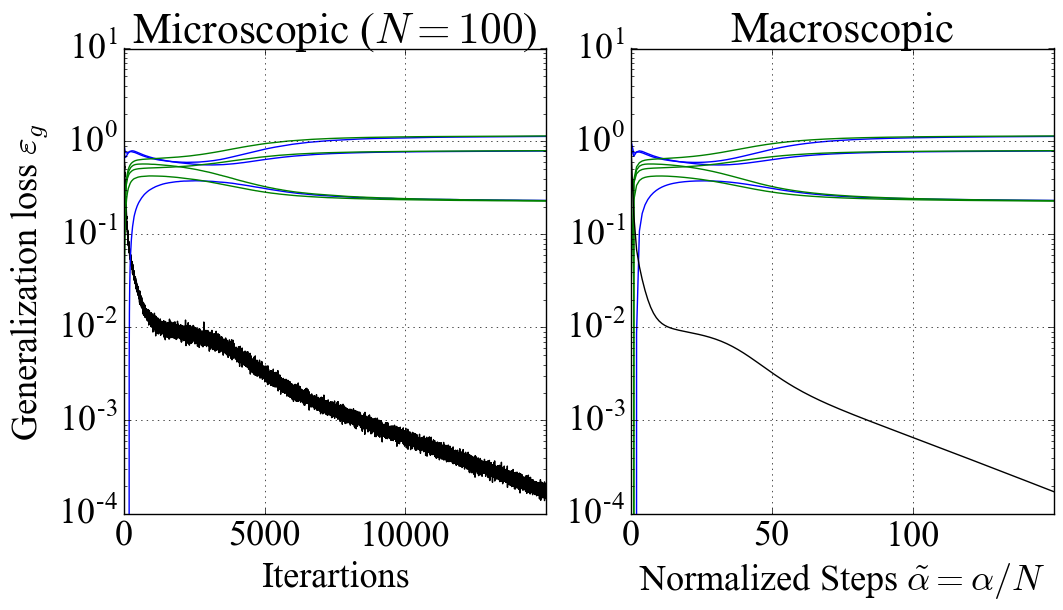

In [74]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plot_micro_dynamics(N, 150*N, Qs, Rs, Ls)
plt.ylim(1e-4, 1e1); plt.xlim(0, 150*N); plt.xticks(np.linspace(0, 100*N, 3)); plt.grid()
plt.xlabel('Iterartions'); plt.ylabel('Generalization loss $\\varepsilon_g$')
plt.title('Microscopic ($N = 100$)')
plt.subplot(122)
plot_macro_dynamics(opL, opQRT[:,0,:,:], N=1)
plt.ylim(1e-4, 1e1); plt.xlim(0, 150); plt.xticks(np.linspace(0, 100, 3)); plt.grid()
plt.xlabel('Normalized Steps $\\tilde{\\alpha} = \\alpha/N$');
plt.title('Macroscopic');
plt.show()

## ミクロ(2)

In [21]:
%%time
N = 100
eta = 0.1
nb_iter = 1500 * N
lambdas = np.array([0.4]*50 + [1.2]*30 + [1.6]*20)

np.random.seed(0) # 乱数初期化
from_scratch = True # 「初めから」 or 「続きから」
rslt = learn(N, nb_iter, lambdas, lr=eta/N, from_scratch=from_scratch, rslt=None)
Qs, Rs, T, Ls, mdl0, mdl_halfway = rslt['Qs'], rslt['Rs'], rslt['T'], rslt['Ls'], rslt['mdl0'], rslt['mdl_halfway']

lambdas: [0.4 0.4 0.4 0.4 0.4] ... [1.6 1.6 1.6 1.6 1.6]
<lambda> 0.8799999999999997
<lambda**2> 1.0240000000000002
<lambda**4> 1.9456
<lambda**2>/<lambda> 1.1636363636363642
sqrt(<lambda**4>/<lambda**2>) 1.3784048752090219
overlap of lambdas and lambdas**2:   0.9703244845221406

CPU times: user 49min 31s, sys: 19min 18s, total: 1h 8min 50s
Wall time: 31min 7s


## マクロ(2)

In [22]:
%%time
nb_iter = 1500
substep = 10
nrslt = calc_opd_highorder(N, nb_iter, lambdas, eta, mdl=rslt['mdl0'], mdl_t=rslt['mdl_t'], ignore_etasq=[False, True], substep=substep)
# ignore_etasqをオンにしていることに注意（つまり学習係数が十分小さい状況）
# オフにすると，ミクロとマクロが一致しない・・・（これはそもそも理論の近似が不十分かもしれない．）
opL, opQRT = nrslt['opL'], nrslt['opQRT']

nQRT: [[[ 7.92192943e-01  1.15116706e-01  7.25525584e-02 -8.50523805e-03]
  [ 1.15116706e-01  9.42786871e-01 -2.25501731e-01  8.01488210e-02]
  [ 7.25525584e-02 -2.25501731e-01  9.16511044e-01  1.00666876e-01]
  [-8.50523805e-03  8.01488210e-02  1.00666876e-01  8.03188652e-01]]

 [[ 8.78433508e-01  1.41963203e-01  1.21382403e-01  1.05506459e-03]
  [ 1.41963203e-01  1.11441190e+00 -3.50164509e-01  1.25961628e-01]
  [ 1.21382403e-01 -3.50164509e-01  1.11241018e+00  1.01609650e-01]
  [ 1.05506459e-03  1.25961628e-01  1.01609650e-01  9.85887841e-01]]

 [[ 1.18562265e+00  1.97577067e-01  1.84996580e-01  1.01583585e-02]
  [ 1.97577067e-01  1.52738315e+00 -5.45855994e-01  2.03440873e-01]
  [ 1.84996580e-01 -5.45855994e-01  1.50499722e+00  1.05232357e-01]
  [ 1.01583585e-02  2.03440873e-01  1.05232357e-01  1.38430424e+00]]]
nABC: [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
sqrt(nT4/nT2):  [[1.38639205 1.01733199]
 [1.01733199 1.44182545]]
nT2/nT1:  [[1.21374444 1.00936528]
 [1

## ミクロとマクロ(2)

In [23]:
def set_label(ax, label, loc='upper right', borderpad=-1, bbox_to_anchor=(0, 1), **kwargs):
    legend = ax.get_legend()
    if legend:
        ax.add_artist(legend)
    line, = ax.plot(np.NaN, np.NaN, color='none',label=label)
    label_legend = ax.legend(handles=[line], loc=loc, handlelength=0, handleheight=0, handletextpad=0, borderaxespad=0, borderpad=borderpad, frameon=False, bbox_to_anchor=bbox_to_anchor, **kwargs)
    label_legend.remove()
    ax.add_artist(label_legend)
    line.remove()

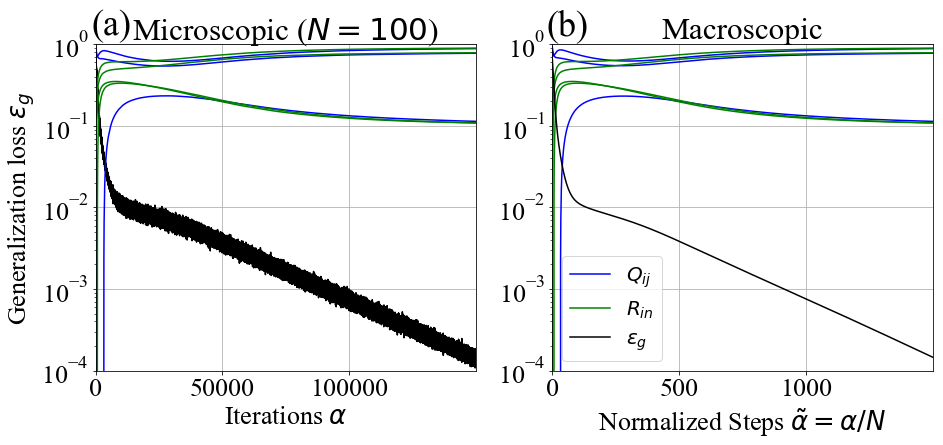

In [32]:
plt.figure(figsize=(15,6))
plt.subplot(121)
plot_micro_dynamics(N, 1500*N, Qs, Rs, Ls)
plt.ylim(1e-4, 1e0); plt.xlim(0, 1500*N); plt.xticks(np.linspace(0, 1000*N, 3)); plt.grid()
plt.xlabel('Iterations $\\alpha$'); plt.ylabel('Generalization loss $\\varepsilon_g$')
plt.title('Microscopic ($N = 100$)')
set_label(plt.gca(), '(a)', fontsize=36)
plt.subplot(122)
plot_macro_dynamics(opL, opQRT[:,0,:,:], N=1)
plt.ylim(1e-4, 1e0); plt.xlim(0, 1500); plt.xticks(np.linspace(0, 1000, 3)); plt.grid()
plt.xlabel('Normalized Steps $\\tilde{\\alpha} = \\alpha/N$');
plt.title('Macroscopic')
set_label(plt.gca(), '(b)', fontsize=36)

plt.savefig('./figures/micro_vs_macro2.pdf', bbox_inches='tight', pad_inches=0) # For Figure
plt.show()

In [34]:
lams = get_iris_lambdas()
print(np.mean(lams), np.mean(lams**2))

15.89366666666667 942.8780409511116


In [35]:
lams = get_mnist_lambdas()
print(np.mean(lams), np.mean(lams**2))

0.11200259182975345 1.9497576238281433


In [206]:
%autoreload

In [135]:
# 色々な固有値分布でオーパラの数値解をたくさん保存するよ その1 [0, ..., 0, lam, ..., lam] (lamの割合は p)
for lam in [0.9, 0.8, 0.7, 0.6, 0.4, 0.3, 0.2, 0.1]: #[0.03125, 0.0625, 0.125, 0.25, 0.5, 1.0]:
    for p in [1.0]:#[0.1, 0.2, 0.5, 1.0]:
        for i in range(5):
            num = int(N * p)
            lambdas = np.array([0.0] * (N - num) + [lam] * num)
            nb_iter = 3000
            eta = 1.0
            nrslt = calc_opd(N, nb_iter, lambdas, eta)
            
            pathname = './SCM_erf2_ST_N100_macro_onenonzeroLambda/lam={},p={}'.format(lam, p)
            os.makedirs(pathname, exist_ok=True)
            np.savez(pathname+'/{}.npz'.format(i),
                     opL=nrslt['opL'], opQRT=nrslt['opQRT'],
                     mdl0=nrslt['mdl0'], mdl_t=nrslt['mdl_t'])
            
            plot_macro_dynamics(nrslt['opL'], nrslt['opQRT'], N=N)
            plt.savefig(pathname+'/{}.png'.format(i))
            plt.close()

nQRT: [[ 0.7980622   0.00465667  0.13333231 -0.0472992 ]
 [ 0.00465667  1.17569093  0.0878695  -0.02269846]
 [ 0.13333231  0.0878695   0.94497965  0.07357106]
 [-0.0472992  -0.02269846  0.07357106  1.02925887]]
nABC: [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
sqrt(nT4/nT2):  [[0.9 0.9]
 [0.9 0.9]]
nT2/nT1:  [[0.9 0.9]
 [0.9 0.9]]
QRTcoef:  [0.9        0.85048168]

nQRT: [[ 0.7736157   0.09532977 -0.04629263  0.05913871]
 [ 0.09532977  0.97798764  0.18036748 -0.03544595]
 [-0.04629263  0.18036748  1.05847791  0.03511911]
 [ 0.05913871 -0.03544595  0.03511911  0.96462831]]
nABC: [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
sqrt(nT4/nT2):  [[0.9 0.9]
 [0.9 0.9]]
nT2/nT1:  [[0.9 0.9]
 [0.9 0.9]]
QRTcoef:  [0.9        0.95263012]

nQRT: [[ 0.94167465  0.06138113  0.01852764  0.07157239]
 [ 0.06138113  0.88130724  0.03933752 -0.00730193]
 [ 0.01852764  0.03933752  1.00775171  0.03702097]
 [ 0.07157239 -0.00730193  0.03702097  0.70008514]]
nABC: [[1. 1. 1. 1.

In [195]:
# 色々な固有値分布でオーパラの数値解をたくさん保存するよ その2 [0, ..., 0, lam, ..., lam] (lamの割合は p)
# 初期値を共通化！ ⇨ 初期値に依存したプラトーの出方とかのばらつきを考えずに比較可能に．
# 乱数のタネを一時的に固定して重みを生成するよ
randstate = np.random.get_state()
np.random.seed(42)
ms = MLP(ls=[N,2,1], nobias=True, act=func_erf2, opt=None)
mt = MLP(ls=[N,2,1], nobias=True, act=func_erf2, opt=None)
np.random.set_state(randstate)
ms.l[1].W.data = np.array([[1, 1]], dtype=np.float32) 
mt.l[1].W.data = np.array([[1, 1]], dtype=np.float32) 

for lam in [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]:
    for p in [1.0, 0.9, 0.8, 0.7, 0.6, 0.5]:
        for i in range(1):
            num = int(N * p)
            lambdas = np.array([0.0] * (N - num) + [lam] * num)
            nb_iter = 10000
            eta = 1.0
            nrslt = calc_opd(N, nb_iter, lambdas, eta, mdl=ms, mdl_t=mt, goal_loss=1e-10)
            
            pathname = './SCM_erf2_ST_N100_macro_onenonzeroLambda_commonInit/lam={},p={}'.format(lam, p)
            os.makedirs(pathname, exist_ok=True)
            np.savez(pathname+'/{}.npz'.format(i),
                     opL=nrslt['opL'], opQRT=nrslt['opQRT'],
                     mdl0=nrslt['mdl0'], mdl_t=nrslt['mdl_t'])
            
            plot_macro_dynamics(nrslt['opL'], nrslt['opQRT'], N=N)
            plt.savefig(pathname+'/{}.png'.format(i))
            plt.close()

nQRT: [[ 0.76018373 -0.12734675  0.04005091 -0.02431084]
 [-0.12734675  0.83298077  0.10203625 -0.0103973 ]
 [ 0.04005091  0.10203625  0.950565    0.00585364]
 [-0.02431084 -0.0103973   0.00585364  0.75901313]]
nABC: [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
sqrt(nT4/nT2):  [[1. 1.]
 [1. 1.]]
nT2/nT1:  [[1. 1.]
 [1. 1.]]
QRTcoef:  [1.       0.950565]
nb_iter: 10000

nQRT: [[ 6.46323288e-01 -6.66840208e-02  3.76004798e-02  3.54307969e-03]
 [-6.66840208e-02  7.01781072e-01  8.96127242e-02 -3.92111132e-04]
 [ 3.76004798e-02  8.96127242e-02  8.33066939e-01  1.17198879e-02]
 [ 3.54307969e-03 -3.92111132e-04  1.17198879e-02  7.18065205e-01]]
nABC: [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
sqrt(nT4/nT2):  [[1. 1.]
 [1. 1.]]
nT2/nT1:  [[1. 1.]
 [1. 1.]]
QRTcoef:  [1.         0.83306694]
nb_iter: 10000

nQRT: [[ 0.58178317 -0.11062954  0.02673827  0.01119818]
 [-0.11062954  0.58084601  0.11321518  0.00329713]
 [ 0.02673827  0.11321518  0.76106887  0.0693880

In [23]:
def analyze_loss_curve(loss_curve):
    '''
    loss_curve: loss の時間発展が格納された1d array
    '''
    converged_flg = np.flatnonzero(loss_curve < 1e-10)
    if len(converged_flg) == 0:
        return {'converge_time': np.inf}
    
    converge_time = np.min(converged_flg)
    log_loss_curve = np.log(loss_curve[:converge_time])
    diff = log_loss_curve[1:] - log_loss_curve[:-1]
    converge_logspeed = diff[-1] # < 0
    plateau_flg = diff > converge_logspeed / 2
    plateau_time_info = []
    plateau_logheight_info = []
    frac = np.zeros(2)
    if plateau_flg[0]: plateau_time_info.append(0)
    for i in range(1,len(plateau_flg)):
        frac += np.array([log_loss_curve[i], 1])
        if plateau_flg[i-1] != plateau_flg[i]:
            plateau_time_info.append(i)
            if len(plateau_time_info) % 2 == 0:
                plateau_logheight_info.append(frac[0]/frac[1])
            frac = np.zeros(2)
    if plateau_flg[-1]:
        plateau_time_info.append(len(plateau_flg))       
        if len(plateau_time_info) % 2 == 0:
            plateau_logheight_info.append(frac[0]/frac[1])

    return {
        'converge_time': converge_time,
        'converge_logspeed': converge_logspeed,
        'plateau_time_info': plateau_time_info, 
        'plateau_logheight_info': plateau_logheight_info         
    }

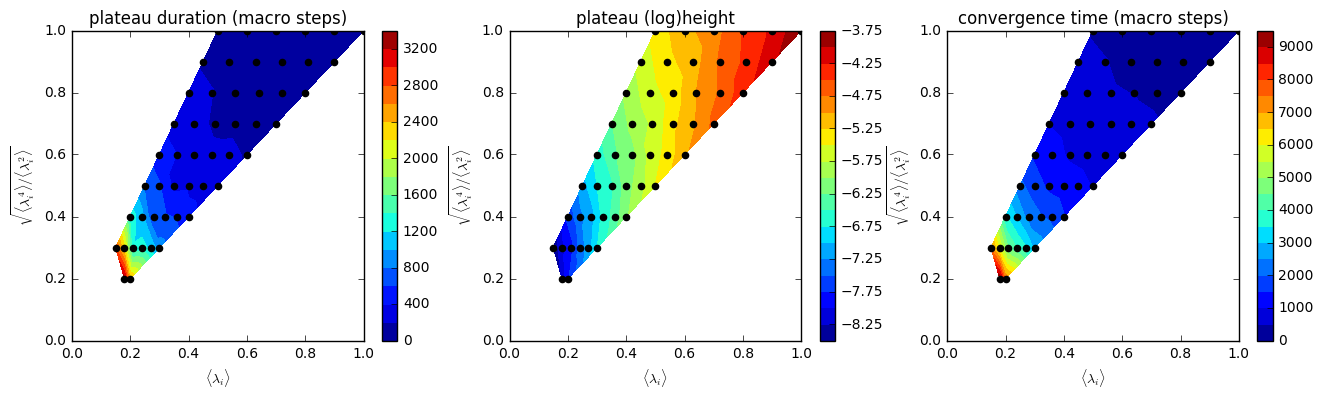

In [29]:
m1_list, sqm4m2_list, h_list, d_list, t_list = [], [], [], [], []
pathname = './SCM_erf2_ST_N100_macro_onenonzeroLambda_commonInit/'

for filename in glob.glob(pathname + '*/*.npz'):
    npz = np.load(filename)
    lam, p = map(float, re.match('.*lam=(.*),p=(.*)/.*', filename).groups())
    # print(npz['opL'].shape) # (1001,) この 1 はミクロでの N(=100) step に相当するので注意．
    lossinfo = analyze_loss_curve(npz['opL'])
    if lossinfo['converge_time'] < np.inf: # 収束している場合
        assert(len(lossinfo['plateau_time_info']) <= 2) # プラトーには高々一度しか入っていないことを確認
        if len(lossinfo['plateau_time_info']) > 0:
            plateau_macrostep = lossinfo['plateau_time_info'][1] - lossinfo['plateau_time_info'][0]
            plateau_logheight = lossinfo['plateau_logheight_info'][0]
        else:
            plateau_macrostep = 0
            plateau_logheight = np.nan
        # (マクロ1ステップは， ミクロNステップ)
        m1_list.append(lam * p)
        sqm4m2_list.append(lam)
        d_list.append(plateau_macrostep)
        h_list.append(plateau_logheight)
        t_list.append(lossinfo['converge_time'])

m1_list = np.array(m1_list)        
sqm4m2_list = np.array(sqm4m2_list)        
d_list = np.array(d_list)        
h_list = np.array(h_list)        
t_list = np.array(t_list)        
        
plt.figure(figsize=(16,4))
plt.subplot(131)
plt.tricontourf(m1_list, sqm4m2_list, d_list, 20)
plt.xlim(0, 1); plt.ylim(0, 1); plt.title('plateau duration (macro steps)');
plt.xlabel('$\\langle\\lambda_i\\rangle$'); plt.ylabel('$\\sqrt{\\langle\\lambda_i^4\\rangle/\\langle\\lambda_i^2\\rangle}$')
ax = plt.gca()
plt.colorbar()
ax.scatter(m1_list, sqm4m2_list, color='k')
plt.subplot(132)
valid_idx = np.flatnonzero(h_list == h_list) # nan検出
plt.tricontourf(m1_list[valid_idx], sqm4m2_list[valid_idx], h_list[valid_idx], 20) # tricontourf に np.nan 投げると kernelが死ぬのを回避している
plt.xlim(0, 1); plt.ylim(0, 1); plt.title('plateau (log)height')
plt.xlabel('$\\langle\\lambda_i\\rangle$'); plt.ylabel('$\\sqrt{\\langle\\lambda_i^4\\rangle/\\langle\\lambda_i^2\\rangle}$')
ax = plt.gca()
plt.colorbar()
ax.scatter(m1_list, sqm4m2_list, color='k')
plt.subplot(133)
plt.tricontourf(m1_list, sqm4m2_list, t_list, 20)
plt.xlim(0, 1); plt.ylim(0, 1); plt.title('convergence time (macro steps)');
plt.xlabel('$\\langle\\lambda_i\\rangle$'); plt.ylabel('$\\sqrt{\\langle\\lambda_i^4\\rangle/\\langle\\lambda_i^2\\rangle}$')
ax = plt.gca()
plt.colorbar()
ax.scatter(m1_list, sqm4m2_list, color='k')
plt.show()

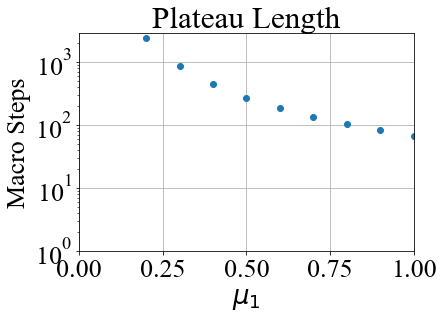

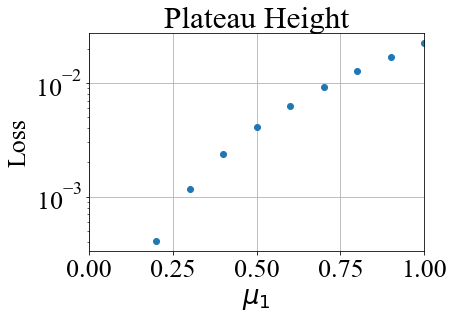

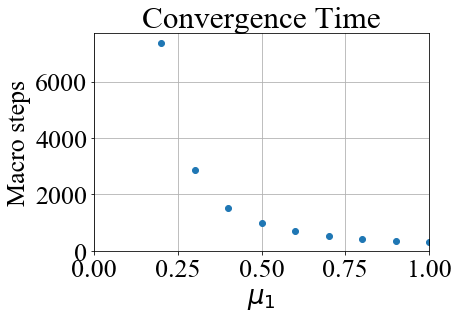

In [150]:
# 上図の対角線部分は p=1 部分，すなわち [lam, ..., lam] の固有値分布の部分なんだけど，
# その部分の結果だけをグラフにしてみるよ
m1_list, sqm4m2_list, h_list, d_list, t_list = [], [], [], [], []
pathname = './three-layer_committee_general_Sigma_results/SCM_erf2_ST_N100_macro_onenonzeroLambda_commonInit/'

for filename in glob.glob(pathname + '*/*.npz'):
    npz = np.load(filename)
    lam, p = map(float, re.match('.*lam=(.*),p=(.*)/.*', filename).groups())
    if p == 1:
        lossinfo = analyze_loss_curve(npz['opL'])
        if lossinfo['converge_time'] < np.inf: # 収束している場合
            assert(len(lossinfo['plateau_time_info']) <= 2) # プラトーには高々一度しか入っていないことを確認
            if len(lossinfo['plateau_time_info']) > 0:
                plateau_macrostep = lossinfo['plateau_time_info'][1] - lossinfo['plateau_time_info'][0]
                plateau_logheight = lossinfo['plateau_logheight_info'][0]
            else:
                plateau_macrostep = 0
                plateau_logheight = np.nan
            # (マクロ1ステップは， ミクロNステップ)
            m1_list.append(lam * p)
            sqm4m2_list.append(lam)
            d_list.append(plateau_macrostep)
            h_list.append(plateau_logheight)
            t_list.append(lossinfo['converge_time'])

# plt.figure(figsize=(16,4))
plt.figure(figsize=(6,4))
# plt.subplot(131)
plt.plot(m1_list, d_list, linestyle='', marker='.', markersize=12)
plt.title('Plateau Length');
plt.yscale('log')
plt.xlim(0, 1); plt.ylim(1, None)
plt.grid()
plt.xlabel('$\\mu_1$'); plt.ylabel('Macro Steps')
plt.savefig('figures/pl_with_various_mu1.pdf', bbox_inches='tight', pad_inches=0)
plt.show()
# plt.subplot(132)
plt.plot(m1_list, np.exp(h_list), linestyle='', marker='.', markersize=12)
plt.yscale('log')
plt.xlim(0, 1)
plt.title('Plateau Height')
plt.grid()
plt.xlabel('$\\mu_1$'); plt.ylabel('Loss')
plt.savefig('figures/ph_with_various_mu1.pdf', bbox_inches='tight', pad_inches=0)
plt.show()
# plt.subplot(133)
plt.plot(m1_list, t_list, linestyle='', marker='.', markersize=12)
plt.title('Convergence Time');
plt.xlim(0, 1); plt.ylim(0, None)
plt.grid()
plt.xlabel('$\\mu_1$'); plt.ylabel('Macro steps')
plt.savefig('figures/ct_with_various_mu1.pdf', bbox_inches='tight', pad_inches=0)
plt.show()
# plt.show()

In [82]:
def set_label(ax, label, loc='upper right', borderpad=-1, bbox_to_anchor=(0, 1), **kwargs):
    legend = ax.get_legend()
    if legend:
        ax.add_artist(legend)
    line, = ax.plot(np.NaN, np.NaN, color='none',label=label)
    label_legend = ax.legend(handles=[line], loc=loc, handlelength=0, handleheight=0, handletextpad=0, borderaxespad=0, borderpad=borderpad, frameon=False, bbox_to_anchor=bbox_to_anchor, **kwargs)
    label_legend.remove()
    ax.add_artist(label_legend)
    line.remove()

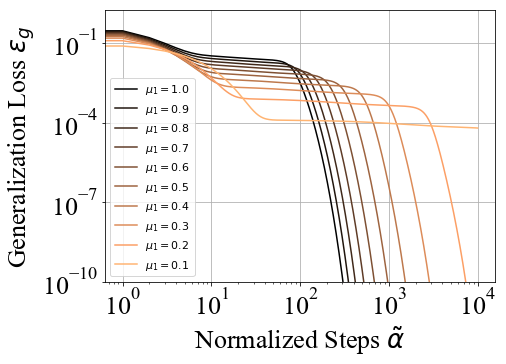

In [127]:
# 生の学習曲線も見ておこう 
pathname = './three-layer_committee_general_Sigma_results/SCM_erf2_ST_N100_macro_onenonzeroLambda_commonInit/'
plt.figure(figsize=(7,5))
for filename in sorted(glob.glob(pathname + '*/*.npz'))[::-1]:
    npz = np.load(filename)
    lam, p = map(float, re.match('.*lam=(.*),p=(.*)/.*', filename).groups())
    if p == 1:
        opL = npz['opL']
        if opL[-1] != opL[-1] or opL[-1] == np.inf or opL[-1] == -np.inf:
            print('!!', filename, ':diverged')
            continue
        plt.plot(np.arange(len(opL)), opL, c=cm.copper_r(lam), label='$\\mu_1 = {}$'.format(lam))
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Normalized Steps $\\tilde{\\alpha}$')
plt.ylabel('Generalization Loss $\\varepsilon_g$')
plt.ylim(1e-10, None)
plt.grid()
plt.legend(fontsize=11)
plt.savefig('./figures/dynamics_with_various_mu1.pdf' , bbox_inches='tight', pad_inches=0) # For Figure
plt.show()

In [219]:
# なお，erfではなくidの場合は・・・

In [39]:
# 色々な固有値分布でオーパラの数値解をたくさん保存するよ その2 [0, ..., 0, lam, ..., lam] (lamの割合は p)              の，  id  バージョン
# 初期値を共通化！ ⇨ 初期値に依存したプラトーの出方とかのばらつきを考えずに比較可能に．
# 乱数のタネを一時的に固定して重みを生成するよ
N = 100
randstate = np.random.get_state()
np.random.seed(42)
ms = MLP(ls=[N,2,1], nobias=True, act=F.identity, opt=None)
mt = MLP(ls=[N,2,1], nobias=True, act=F.identity, opt=None)
np.random.set_state(randstate)
ms.l[1].W.data = np.array([[1, 1]], dtype=np.float32) 
mt.l[1].W.data = np.array([[1, 1]], dtype=np.float32) 

for lam in [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]:
    for p in [1.0, 0.9, 0.8, 0.7, 0.6, 0.5]:
        for i in range(1):
            num = int(N * p)
            lambdas = np.array([0.0] * (N - num) + [lam] * num)
            nb_iter = 10000
            eta = 1.0
            nrslt = calc_opd(N, nb_iter, lambdas, eta, mdl=ms, mdl_t=mt, goal_loss=1e-10, act='id')
            
            pathname = './SCM_id_ST_N100_macro_onenonzeroLambda_commonInit/lam={},p={}'.format(lam, p)
            os.makedirs(pathname, exist_ok=True)
            np.savez(pathname+'/{}.npz'.format(i),
                     opL=nrslt['opL'], opQRT=nrslt['opQRT'],
                     mdl0=nrslt['mdl0'], mdl_t=nrslt['mdl_t'])
            
            plot_macro_dynamics(nrslt['opL'], nrslt['opQRT'], N=N)
            plt.savefig(pathname+'/{}.png'.format(i))
            plt.close()

nQRT: [[ 0.8273063  -0.1192889   0.05954009 -0.00732629]
 [-0.1192889   0.90088715  0.11283072 -0.02027471]
 [ 0.05954009  0.11283072  1.17370965  0.02937043]
 [-0.00732629 -0.02027471  0.02937043  0.80423793]]
nABC: [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
sqrt(nT4/nT2):  [[1. 1.]
 [1. 1.]]
nT2/nT1:  [[1. 1.]
 [1. 1.]]
QRTcoef:  [1.         1.17370965]
nb_iter: 10000


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
/Users/yoshidayuuki/Documents/lab/momentumSGD/order_parameter_dynamics.py:467: RuntimeWarning: overflow encountered in double_scalars
  ret[i,k] -= self.QRTcoef[0] * self.eta * (ABC[i, j] * self.I3(QRT, i, k, j) + ABC[k, j] * self.I3(QRT, k, i, j))
/Users/yoshidayuuki/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/matplotlib/scale.py:123: RuntimeWarning: overflow encountered in multiply
  a = self._handle_nonpos(a * 10.0)
/Users/yoshidayuuki/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/yoshidayuuki/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/matplotlib/ticker.py:1597: RuntimeWarning: overflow encountered in powe


nQRT: [[ 0.76018373 -0.12734675  0.04005091 -0.02431084]
 [-0.12734675  0.83298077  0.10203625 -0.0103973 ]
 [ 0.04005091  0.10203625  0.950565    0.00585364]
 [-0.02431084 -0.0103973   0.00585364  0.75901313]]
nABC: [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
sqrt(nT4/nT2):  [[1. 1.]
 [1. 1.]]
nT2/nT1:  [[1. 1.]
 [1. 1.]]
QRTcoef:  [1.       0.950565]
nb_iter: 10000


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 12, in zmq.backend.cython.checkrc._check_rc (zmq/backend/cython/message.c:4018)
KeyboardInterrupt


nQRT: [[ 6.46323288e-01 -6.66840208e-02  3.76004798e-02  3.54307969e-03]
 [-6.66840208e-02  7.01781072e-01  8.96127242e-02 -3.92111132e-04]
 [ 3.76004798e-02  8.96127242e-02  8.33066939e-01  1.17198879e-02]
 [ 3.54307969e-03 -3.92111132e-04  1.17198879e-02  7.18065205e-01]]
nABC: [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
sqrt(nT4/nT2):  [[1. 1.]
 [1. 1.]]
nT2/nT1:  [[1. 1.]
 [1. 1.]]
QRTcoef:  [1.         0.83306694]
nb_iter: 10000


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"



nQRT: [[ 0.58178317 -0.11062954  0.02673827  0.01119818]
 [-0.11062954  0.58084601  0.11321518  0.00329713]
 [ 0.02673827  0.11321518  0.76106887  0.06938801]
 [ 0.01119818  0.00329713  0.06938801  0.60715116]]
nABC: [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
sqrt(nT4/nT2):  [[1. 1.]
 [1. 1.]]
nT2/nT1:  [[1. 1.]
 [1. 1.]]
QRTcoef:  [1.         0.76106887]
nb_iter: 10000


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"



nQRT: [[ 0.45412594 -0.08132645  0.07279719  0.00232991]
 [-0.08132645  0.4818088   0.11522897  0.02449065]
 [ 0.07279719  0.11522897  0.64740053  0.03015045]
 [ 0.00232991  0.02449065  0.03015045  0.57269876]]
nABC: [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
sqrt(nT4/nT2):  [[1. 1.]
 [1. 1.]]
nT2/nT1:  [[1. 1.]
 [1. 1.]]
QRTcoef:  [1.         0.64740053]
nb_iter: 10000



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


nQRT: [[ 0.37473574 -0.06537551  0.07783007 -0.00610843]
 [-0.06537551  0.39489367  0.12146946  0.01961719]
 [ 0.07783007  0.12146946  0.55817356  0.01627833]
 [-0.00610843  0.01961719  0.01627833  0.49764187]]
nABC: [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
sqrt(nT4/nT2):  [[1. 1.]
 [1. 1.]]
nT2/nT1:  [[1. 1.]
 [1. 1.]]
QRTcoef:  [1.         0.55817356]
nb_iter: 10000



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


nQRT: [[ 0.74457567 -0.10736001  0.05358608 -0.00659366]
 [-0.10736001  0.81079843  0.10154765 -0.01824724]
 [ 0.05358608  0.10154765  1.05633868  0.02643339]
 [-0.00659366 -0.01824724  0.02643339  0.72381413]]
nABC: [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
sqrt(nT4/nT2):  [[0.9 0.9]
 [0.9 0.9]]
nT2/nT1:  [[0.9 0.9]
 [0.9 0.9]]
QRTcoef:  [0.9        0.95070482]
nb_iter: 10000


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


KeyboardInterrupt: 

!! ./SCM_id_ST_N100_macro_onenonzeroLambda_commonInit/lam=0.9,p=1.0/0.npz :diverged
!! ./SCM_id_ST_N100_macro_onenonzeroLambda_commonInit/lam=1.0,p=1.0/0.npz :diverged
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [ 54  55  57  58  59  61  30  31  32  33  34  36  22  23  24  25  27  29
  19  20  21  22  24  27  18  18  20  21  23  28  17  18  19  20  23  33
  18  18  19  21  25  47  18  18  20  23  31 120  18  18  22  27  45  18
  18  25  35 119]


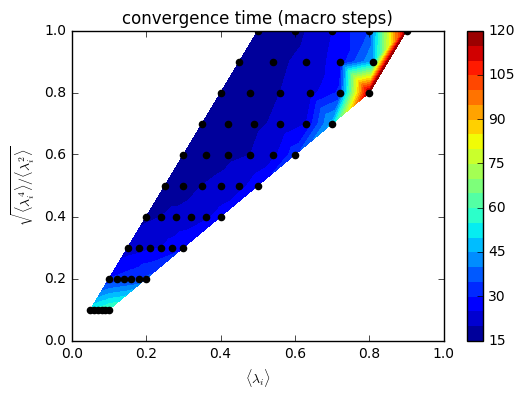

In [58]:
m1_list, sqm4m2_list, h_list, d_list, t_list = [], [], [], [], []
pathname = './SCM_id_ST_N100_macro_onenonzeroLambda_commonInit/'

for filename in glob.glob(pathname + '*/*.npz'):
    npz = np.load(filename)
    lam, p = map(float, re.match('.*lam=(.*),p=(.*)/.*', filename).groups())
    # print(npz['opL'].shape) # (1001,) この 1 はミクロでの N(=100) step に相当するので注意．
    opL = npz['opL']
    if opL[-1] != opL[-1] or opL[-1] == np.inf or opL[-1] == -np.inf:
        print('!!', filename, ':diverged')
        continue
    lossinfo = analyze_loss_curve(npz['opL'])
    if lossinfo['converge_time'] < np.inf: # 収束している場合
        assert(len(lossinfo['plateau_time_info']) <= 2) # プラトーには高々一度しか入っていないことを確認
        if len(lossinfo['plateau_time_info']) > 0:
            plateau_macrostep = lossinfo['plateau_time_info'][1] - lossinfo['plateau_time_info'][0]
            plateau_logheight = lossinfo['plateau_logheight_info'][0]
        else:
            plateau_macrostep = 0
            plateau_logheight = np.nan
        # (マクロ1ステップは， ミクロNステップ)
        m1_list.append(lam * p)
        sqm4m2_list.append(lam)
        d_list.append(plateau_macrostep)
        h_list.append(plateau_logheight)
        t_list.append(lossinfo['converge_time'])

m1_list = np.array(m1_list)        
sqm4m2_list = np.array(sqm4m2_list)        
d_list = np.array(d_list)        
h_list = np.array(h_list)        
t_list = np.array(t_list)        
        
print(d_list, t_list)
# プラトーには入らないのでプラトー長さと高さのグラフは無し．
plt.tricontourf(m1_list, sqm4m2_list, t_list, 20)
plt.xlim(0, 1); plt.ylim(0, 1); plt.title('convergence time (macro steps)');
plt.xlabel('$\\langle\\lambda_i\\rangle$'); plt.ylabel('$\\sqrt{\\langle\\lambda_i^4\\rangle/\\langle\\lambda_i^2\\rangle}$')
ax = plt.gca()
plt.colorbar()
ax.scatter(m1_list, sqm4m2_list, color='k')
plt.show()

!! ./SCM_id_ST_N100_macro_onenonzeroLambda_commonInit/lam=0.9,p=1.0/0.npz :diverged
!! ./SCM_id_ST_N100_macro_onenonzeroLambda_commonInit/lam=1.0,p=1.0/0.npz :diverged


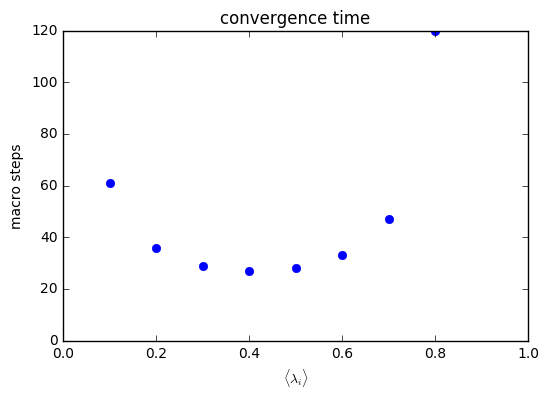

In [57]:
# 上図の対角線部分は p=1 部分，すなわち [lam, ..., lam] の固有値分布の部分なんだけど，
# その部分の結果だけをグラフにしてみるよ
m1_list, sqm4m2_list, h_list, d_list, t_list = [], [], [], [], []
pathname = './SCM_id_ST_N100_macro_onenonzeroLambda_commonInit/'

for filename in glob.glob(pathname + '*/*.npz'):
    npz = np.load(filename)
    lam, p = map(float, re.match('.*lam=(.*),p=(.*)/.*', filename).groups())
    if p == 1:
        opL = npz['opL']
        if opL[-1] != opL[-1] or opL[-1] == np.inf or opL[-1] == -np.inf:
            print('!!', filename, ':diverged')
            continue
        lossinfo = analyze_loss_curve(npz['opL'])
        if lossinfo['converge_time'] < np.inf: # 収束している場合
            assert(len(lossinfo['plateau_time_info']) <= 2) # プラトーには高々一度しか入っていないことを確認
            if len(lossinfo['plateau_time_info']) > 0:
                plateau_macrostep = lossinfo['plateau_time_info'][1] - lossinfo['plateau_time_info'][0]
                plateau_logheight = lossinfo['plateau_logheight_info'][0]
            else:
                plateau_macrostep = 0
                plateau_logheight = np.nan
            # (マクロ1ステップは， ミクロNステップ)
            m1_list.append(lam * p)
            sqm4m2_list.append(lam)
            d_list.append(plateau_macrostep)
            h_list.append(plateau_logheight)
            t_list.append(lossinfo['converge_time'])


plt.plot(m1_list, t_list, linestyle='', marker='.', markersize=12)
plt.title('convergence time');
plt.xlim(0, 1); plt.ylim(0, None)
plt.xlabel('$\\langle\\lambda_i\\rangle$'); plt.ylabel('macro steps')
plt.show()

In [51]:
# 0.9と1.0は微分方程式の数値解が発散した！（収束判定になってるのは，発散直後になぜか +infではなく-infになったため）

In [46]:
# 何れにしても，idとerf2では収束時間の振る舞いが全然違う！

0.1 1.0 62
0.2 1.0 37
0.3 1.0 30
0.4 1.0 28
0.5 1.0 29
0.6 1.0 34
0.7 1.0 48
0.8 1.0 121
!! ./SCM_id_ST_N100_macro_onenonzeroLambda_commonInit/lam=0.9,p=1.0/0.npz :diverged
!! ./SCM_id_ST_N100_macro_onenonzeroLambda_commonInit/lam=1.0,p=1.0/0.npz :diverged


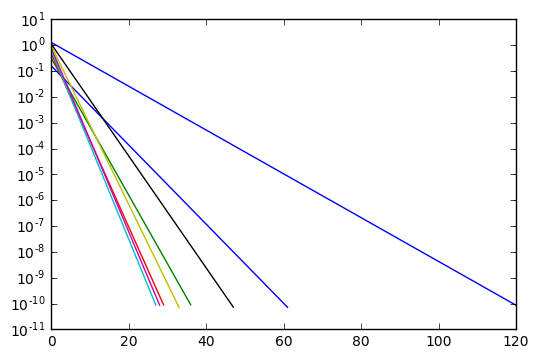

In [290]:
pathname = './SCM_id_ST_N100_macro_onenonzeroLambda_commonInit/'

for filename in glob.glob(pathname + '*/*.npz'):
    npz = np.load(filename)
    lam, p = map(float, re.match('.*lam=(.*),p=(.*)/.*', filename).groups())
    if p == 1:
        opL = npz['opL']
        if opL[-1] != opL[-1] or opL[-1] == np.inf or opL[-1] == -np.inf:
            print('!!', filename, ':diverged')
            continue
        plt.plot(np.arange(len(opL)), opL)
        print(lam, p, len(opL))
plt.yscale('log')
plt.show()

In [47]:
# relu の場合は別仕事にしても良さそう？

In [59]:
# 願わくば，プラトーの深さと長さを解析的に求めたい・・・

In [ ]:
'''
[0, ..., 0, lam1, ..., lam1 (割合p1), lam2, ..., lam2 (割合p2)] のモーメント
mu1 = lam1 * p1 + lam2 * p2
mu2 = lam1**2 * p1 + lam2**2 * p2
'''

In [219]:
# 色々な固有値分布でオーパラの数値解をたくさん保存するよ その3 [lam1, ..., lam1, lam2, ..., lam2] (lam1の割合は p1=0.5, lam2の割合はp2=0.5)
# 初期値を共通化！ ⇨ 初期値に依存したプラトーの出方とかのばらつきを考えずに比較可能に．
# 乱数のタネを一時的に固定して重みを生成するよ
randstate = np.random.get_state()
np.random.seed(42)
ms = MLP(ls=[N,2,1], nobias=True, act=func_erf2, opt=None)
mt = MLP(ls=[N,2,1], nobias=True, act=func_erf2, opt=None)
np.random.set_state(randstate)
ms.l[1].W.data = np.array([[1, 1]], dtype=np.float32) 
mt.l[1].W.data = np.array([[1, 1]], dtype=np.float32) 

p1, p2 = 0.5, 0.5
for lam in [[0.01, 1.99]]:#[[1.0, 1.0], [0.9, 1.1], [0.8, 1.2], [0.7, 1.3], [0.6, 1.4], [0.5, 1.5], [0.4, 1.6], [0.3, 1.7], [0.2, 1.8], [0.1, 1.9]]:
    for i in range(1):
        lam1, lam2 = lam
        num1 = int(N * p1)
        num2 = int(N * p2)
        lambdas = np.sort(np.array([0.0] * (N - num1 - num2) + [lam1] * num1 + [lam2] * num2))

        nb_iter = 10000
        eta = 1.0
        substep = 10  # 数値解法が乱れるので・・・（ルンゲクッタでも・・・）
        nrslt = calc_opd_highorder(N, nb_iter, lambdas, eta, mdl=ms, mdl_t=mt, goal_loss=1e-10, ignore_etasq=[True, True], substep=substep)

        pathname = './three-layer_committee_general_Sigma_results/SCM_erf2_ST_N100_macro_twononzeroLambda_commonInit/lam1={},p1={},lam2={},p2={}'.format(lam1, p1, lam2, p2)
        os.makedirs(pathname, exist_ok=True)
        np.savez(pathname+'/{}.npz'.format(i),
                 opL=nrslt['opL'], opQRT=nrslt['opQRT'],
                 mdl0=nrslt['mdl0'], mdl_t=nrslt['mdl_t'])

        plot_macro_dynamics(nrslt['opL'], nrslt['opQRT'][:,0,:,:], N=N)
        plt.savefig(pathname+'/{}.png'.format(i))
        plt.close()

nQRT: [[[ 0.75024982 -0.13063641  0.15469894 -0.01216795]
  [-0.13063641  0.79089833  0.24163785  0.03863929]
  [ 0.15469894  0.24163785  1.11692074  0.03252481]
  [-0.01216795  0.03863929  0.03252481  0.99337328]]

 [[ 1.48403624 -0.25889896  0.30821304 -0.0241901 ]
  [-0.25889896  1.563869    0.48103036  0.07768206]
  [ 0.30821304  0.48103036  2.21048465  0.06446514]
  [-0.0241901   0.07768206  0.06446514  1.97074223]]]
nABC: [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
sqrt(nT4/nT2):  [[1.98997229 1.98997979]
 [1.98997979 1.98998452]]
nT2/nT1:  [[1.9790882  1.98202998]
 [1.98202998 1.9838889 ]]
poly deg: 2
nb_iter: 10000




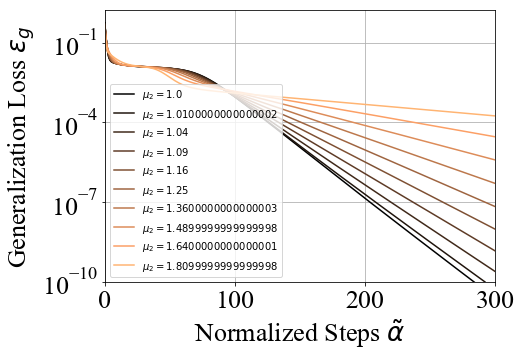

In [115]:
pathname = './three-layer_committee_general_Sigma_results/SCM_erf2_ST_N100_macro_twononzeroLambda_commonInit/'
plt.figure(figsize=(7,5))
for filename in sorted(glob.glob(pathname + '*/*.npz'))[::-1]:
    npz = np.load(filename)
    re_match = re.match('.*lam1=(.*),p1=(.*),lam2=(.*),p2=(.*)/.*', filename)
    if re_match is None: continue
    lam1, p1, lam2, p2 = map(float, re_match.groups())
    mu2 = lam1**2 * p1 + lam2**2 * p2
    if p1 == 0.5 and p2 == 0.5 and lam1 > 0.09:
        opL = npz['opL']
        if opL[-1] != opL[-1] or opL[-1] == np.inf or opL[-1] == -np.inf:
            print('!!', filename, ':diverged')
            continue
        plt.plot(np.arange(len(opL)), opL, c=cm.copper(lam2 - 1), label='$\\mu_2={}$'.format(mu2))
        # print(lam1,p1,lam2,p2, len(opL))
plt.yscale('log')
# plt.ylim(1e-4, 1e0)
# plt.xscale('log')
plt.xlim(0, 300)
plt.xlabel('Normalized Steps $\\tilde{\\alpha}$')
plt.ylabel('Generalization Loss $\\varepsilon_g$')
plt.ylim(1e-10, None)
plt.grid()
plt.legend(fontsize=10, loc='best')
# plt.savefig('./figures/dynamics_with_various_mu2.pdf') # For Figure
plt.show()

/Users/yoshidayuuki/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


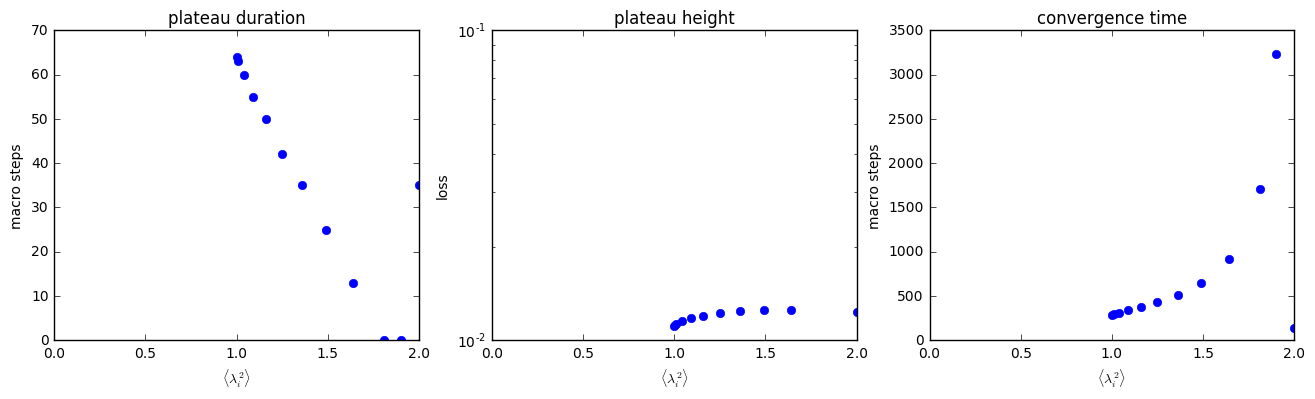

In [305]:
# 一応，プラトーの長さを定量しておこう．
m2_list, h_list, d_list, t_list = [], [], [], []
pathname = './SCM_erf2_ST_N100_macro_twononzeroLambda_commonInit/'

for filename in glob.glob(pathname + '*/*.npz'):
    npz = np.load(filename)
    re_match = re.match('.*lam1=(.*),p1=(.*),lam2=(.*),p2=(.*)/.*', filename)
    if re_match is None: continue
    lam1, p1, lam2, p2 = map(float, re_match.groups())
    if p1 == 0.5 and p2 == 0.5:
        lossinfo = analyze_loss_curve(npz['opL'])
        if lossinfo['converge_time'] < np.inf: # 収束している場合
            if len(lossinfo['plateau_time_info']) > 2: # プラトーには高々一度しか入っていないことを確認
                print('プラトーに二回以上入っているようです:', lossinfo['plateau_time_info'])
            if len(lossinfo['plateau_time_info']) > 0:
                plateau_macrostep = lossinfo['plateau_time_info'][1] - lossinfo['plateau_time_info'][0]
                plateau_logheight = lossinfo['plateau_logheight_info'][0]
            else:
                plateau_macrostep = 0
                plateau_logheight = np.nan
            # (マクロ1ステップは， ミクロNステップ)
            m2_list.append(lam1**2 * p1 + lam2**2 * p2)
            d_list.append(plateau_macrostep)
            h_list.append(plateau_logheight)
            t_list.append(lossinfo['converge_time'])

plt.figure(figsize=(16,4))
plt.subplot(131)
plt.plot(m2_list, d_list, linestyle='', marker='.', markersize=12)
plt.title('plateau duration');
plt.xlim(0, None); plt.ylim(0, None)
plt.xlabel('$\\langle\\lambda_i^2\\rangle$'); plt.ylabel('macro steps')
plt.subplot(132)
plt.plot(m2_list, np.exp(h_list), linestyle='', marker='.', markersize=12)
plt.yscale('log')
plt.xlim(0, None)
plt.title('plateau height')
plt.xlabel('$\\langle\\lambda_i^2\\rangle$'); plt.ylabel('loss')
plt.subplot(133)
plt.plot(m2_list, t_list, linestyle='', marker='.', markersize=12)
plt.title('convergence time');
plt.xlim(0, None); plt.ylim(0, None)
plt.xlabel('$\\langle\\lambda_i^2\\rangle$'); plt.ylabel('macro steps')
plt.show()

### 上は lam1 や lam2 が綺麗な値になるところを調べたが， mu1 や mu2 が綺麗な値になるところを調べるバージョンも作成する．

In [110]:
# 色々な固有値分布でオーパラの数値解をたくさん保存するよ その3.1 [lam1, ..., lam1, lam2, ..., lam2] (lam1の割合は p1=0.5, lam2の割合はp2=0.5)
# 初期値を共通化！ ⇨ 初期値に依存したプラトーの出方とかのばらつきを考えずに比較可能に．
# 乱数のタネを一時的に固定して重みを生成するよ
randstate = np.random.get_state()
np.random.seed(42)
ms = MLP(ls=[N,2,1], nobias=True, act=func_erf2, opt=None)
mt = MLP(ls=[N,2,1], nobias=True, act=func_erf2, opt=None)
np.random.set_state(randstate)
ms.l[1].W.data = np.array([[1, 1]], dtype=np.float32) 
mt.l[1].W.data = np.array([[1, 1]], dtype=np.float32) 

p1, p2 = 0.5, 0.5
for mu in [[1.0, 1.0], [1.0, 1.1], [1.0, 1.2], [1.0, 1.3], [1.0, 1.4], [1.0, 1.5], [1.0, 1.6], [1.0, 1.7], [1.0, 1.8], [1.0, 1.9]]:
    for i in range(1):
        mu1, mu2 = mu
        d = np.sqrt(mu2 - mu1**2)
        lam1, lam2 = mu1 - d, mu1 + d
        num1 = int(N * p1)
        num2 = int(N * p2)
        lambdas = np.sort(np.array([0.0] * (N - num1 - num2) + [lam1] * num1 + [lam2] * num2))

        nb_iter = 10000
        eta = 1.0
        substep = 10  # 数値解法が乱れるので・・・（ルンゲクッタでも・・・）
        nrslt = calc_opd_highorder(N, nb_iter, lambdas, eta, mdl=ms, mdl_t=mt, goal_loss=1e-10, ignore_etasq=[True, True], substep=substep)

        pathname = './three-layer_committee_general_Sigma_results/SCM_erf2_ST_N100_macro_twononzeroLambda_commonInit/mu1={},p1={},mu2={},p2={}'.format(mu1, p1, mu2, p2)
        os.makedirs(pathname, exist_ok=True)
        np.savez(pathname+'/{}.npz'.format(i),
                 opL=nrslt['opL'], opQRT=nrslt['opQRT'],
                 mdl0=nrslt['mdl0'], mdl_t=nrslt['mdl_t'])

        plot_macro_dynamics(nrslt['opL'], nrslt['opQRT'][:,0,:,:], N=N)
        plt.savefig(pathname+'/{}.png'.format(i))
        plt.close()

nQRT: [[[ 0.8273063  -0.1192889   0.05954009 -0.00732629]
  [-0.1192889   0.90088715  0.11283072 -0.02027471]
  [ 0.05954009  0.11283072  1.17370965  0.02937043]
  [-0.00732629 -0.02027471  0.02937043  0.80423793]]]
nABC: [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
sqrt(nT4/nT2):  [[1. 1.]
 [1. 1.]]
nT2/nT1:  [[1. 1.]
 [1. 1.]]
poly deg: 1
nb_iter: 10000
nQRT: [[[ 0.80269276 -0.12291354  0.08993592 -0.00887282]
  [-0.12291354  0.8657543   0.15397455 -0.00145628]
  [ 0.08993592  0.15397455  1.15557002  0.03037801]
  [-0.00887282 -0.00145628  0.03037801  0.86465192]]

 [[ 0.86080986 -0.13846708  0.12628576 -0.01115198]
  [-0.13846708  0.92071017  0.20640145  0.01533468]
  [ 0.12628576  0.20640145  1.25480136  0.03432263]
  [-0.01115198  0.01533468  0.03432263  1.0054897 ]]]
nABC: [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
sqrt(nT4/nT2):  [[1.20097725 1.22754626]
 [1.22754626 1.24584266]]
nT2/nT1:  [[1.0858722  1.12985118]
 [1.12985118 1.16288379]]
poly 

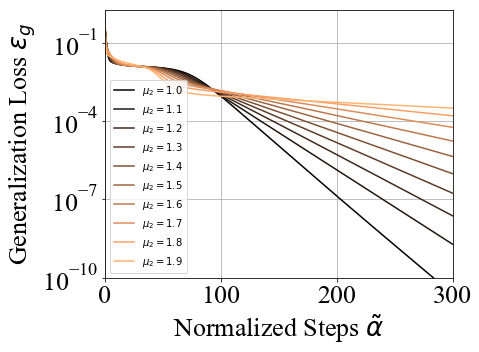

In [126]:
pathname = './three-layer_committee_general_Sigma_results/SCM_erf2_ST_N100_macro_twononzeroLambda_commonInit/'
plt.figure(figsize=(7,5.3))
plt.subplots_adjust(bottom=0.18, left=0.21)
for filename in sorted(glob.glob(pathname + '*/*.npz')):
    npz = np.load(filename)
    re_match = re.match('.*mu1=(.*),p1=(.*),mu2=(.*),p2=(.*)/.*', filename)
    if re_match is None: continue
    mu1, p1, mu2, p2 = map(float, re_match.groups())
    if p1 == 0.5 and p2 == 0.5:
        opL = npz['opL']
        if opL[-1] != opL[-1] or opL[-1] == np.inf or opL[-1] == -np.inf:
            print('!!', filename, ':diverged')
            continue
        plt.plot(np.arange(len(opL)), opL, c=cm.copper(mu2 - 1), label='$\\mu_2={}$'.format(mu2))
        # print(lam1,p1,lam2,p2, len(opL))
plt.yscale('log')
# plt.ylim(1e-4, 1e0)
# plt.xscale('log')
plt.xlim(0, 300)
plt.xlabel('Normalized Steps $\\tilde{\\alpha}$')
plt.ylabel('Generalization Loss $\\varepsilon_g$')
plt.ylim(1e-10, None)
plt.grid()
plt.legend(fontsize=10, loc='best')
plt.savefig('./figures/dynamics_with_various_mu2.pdf', bbox_inches='tight', pad_inches=0) # For Figure
plt.show()

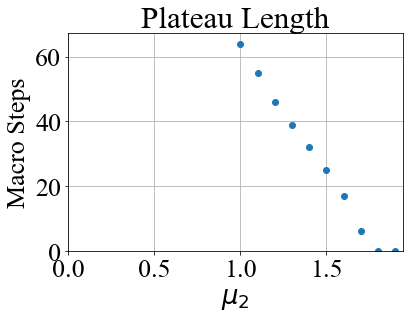

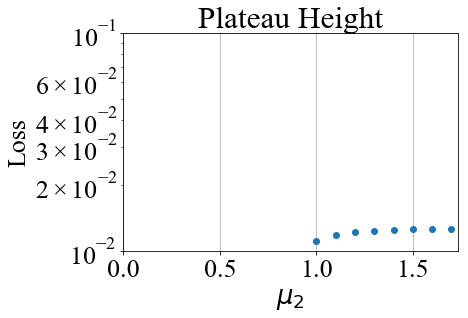

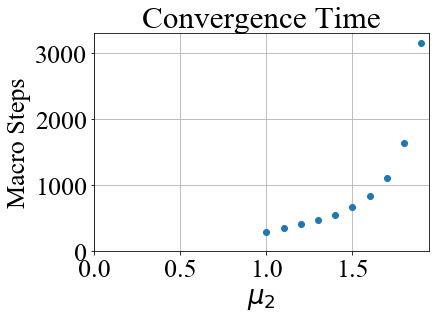

In [184]:
# プラトーの長さを定量しておこう．
m2_list, h_list, d_list, t_list = [], [], [], []
pathname = './three-layer_committee_general_Sigma_results/SCM_erf2_ST_N100_macro_twononzeroLambda_commonInit/'

for filename in glob.glob(pathname + '*/*.npz'):
    npz = np.load(filename)
    re_match = re.match('.*mu1=(.*),p1=(.*),mu2=(.*),p2=(.*)/.*', filename)
    if re_match is None: continue
    mu1, p1, mu2, p2 = map(float, re_match.groups())
    if p1 == 0.5 and p2 == 0.5:
        lossinfo = analyze_loss_curve(npz['opL'])
        if lossinfo['converge_time'] < np.inf: # 収束している場合
            if len(lossinfo['plateau_time_info']) > 2: # プラトーには高々一度しか入っていないことを確認
                print('プラトーに二回以上入っているようです:', lossinfo['plateau_time_info'])
            if len(lossinfo['plateau_time_info']) > 0:
                plateau_macrostep = lossinfo['plateau_time_info'][1] - lossinfo['plateau_time_info'][0]
                plateau_logheight = lossinfo['plateau_logheight_info'][0]
            else:
                plateau_macrostep = 0
                plateau_logheight = np.nan
            # (マクロ1ステップは， ミクロNステップ)
            m2_list.append(mu2)
            d_list.append(plateau_macrostep)
            h_list.append(plateau_logheight)
            t_list.append(lossinfo['converge_time'])

# plt.figure(figsize=(16,4))
plt.figure(figsize=(6,4))
# plt.subplot(131)
plt.plot(m2_list, d_list, linestyle='', marker='.', markersize=12)
plt.title('Plateau Length');
plt.xlim(0, None); plt.ylim(0, None)
plt.grid()
plt.xlabel('$\\mu_2$'); plt.ylabel('Macro Steps')
plt.savefig('figures/pl_with_various_mu2.pdf', bbox_inches='tight', pad_inches=0)
plt.show()
# plt.subplot(132)
plt.plot(m2_list, np.exp(h_list), linestyle='', marker='.', markersize=12)
plt.yscale('log')
plt.xlim(0, None)
plt.ylim(1e-2, 1e-1)
plt.title('Plateau Height')
plt.grid()
plt.xlabel('$\\mu_2$'); plt.ylabel('Loss')
plt.savefig('figures/ph_with_various_mu2.pdf', bbox_inches='tight', pad_inches=0)
plt.show()
# plt.subplot(133)
plt.plot(m2_list, t_list, linestyle='', marker='.', markersize=12)
plt.title('Convergence Time');
plt.xlim(0, None); plt.ylim(0, None)
plt.grid()
plt.xlabel('$\\mu_2$'); plt.ylabel('Macro Steps')
plt.savefig('figures/ct_with_various_mu2.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

In [287]:
# 色々な固有値分布でオーパラの数値解をたくさん保存するよ その4 [lam1, ..., lam1, lam2, ..., lam2] (lam1の割合は p1, lam2の割合はp2)
# 平均 1, lam1:lam2 = p2:p1 をみたすように調整
# 初期値を共通化！ ⇨ 初期値に依存したプラトーの出方とかのばらつきを考えずに比較可能に．
# 乱数のタネを一時的に固定して重みを生成するよ
randstate = np.random.get_state()
np.random.seed(42)
ms = MLP(ls=[N,2,1], nobias=True, act=func_erf2, opt=None)
mt = MLP(ls=[N,2,1], nobias=True, act=func_erf2, opt=None)
np.random.set_state(randstate)
ms.l[1].W.data = np.array([[1, 1]], dtype=np.float32) 
mt.l[1].W.data = np.array([[1, 1]], dtype=np.float32) 

for p1 in [0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98, 0.99]:
    for i in range(1):
        p2 = 1.0 - p1
        lam1 = 0.5 / p1
        lam2 = 0.5 / p2
        num1 = int(N * p1 + 0.5)
        num2 = int(N * p2 + 0.5)
        lambdas = np.sort(np.array([0.0] * (N - num1 - num2) + [lam1] * num1 + [lam2] * num2))

        nb_iter = 10000
        eta = 1.0
        substep = 10 # 数値解法が乱れるので・・・（ルンゲクッタでも・・・）
        nrslt = calc_opd_highorder(N, nb_iter, lambdas, eta, mdl=ms, mdl_t=mt, goal_loss=1e-10, ignore_etasq=[True, True], substep=substep)

        pathname = './SCM_erf2_ST_N100_macro_twononzeroLambda_jikken2_commonInit/lam1={},p1={},lam2={},p2={}'.format(lam1, p1, lam2, p2)
        os.makedirs(pathname, exist_ok=True)
        np.savez(pathname+'/{}.npz'.format(i),
                 opL=nrslt['opL'], opQRT=nrslt['opQRT'],
                 mdl0=nrslt['mdl0'], mdl_t=nrslt['mdl_t'])

        plot_macro_dynamics(nrslt['opL'], nrslt['opQRT'][:,0,:,:], N=N)
        plt.savefig(pathname+'/{}.png'.format(i))
        plt.close()

nQRT: [[[ 0.8273063  -0.1192889   0.05954009 -0.00732629]
  [-0.1192889   0.90088715  0.11283072 -0.02027471]
  [ 0.05954009  0.11283072  1.17370965  0.02937043]
  [-0.00732629 -0.02027471  0.02937043  0.80423793]]]
nABC: [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
sqrt(nT4/nT2):  [[1. 1.]
 [1. 1.]]
nT2/nT1:  [[1. 1.]
 [1. 1.]]
poly deg: 1
nb_iter: 10000

nQRT: [[[ 0.82523991 -0.12131642  0.0791605  -0.01324849]
  [-0.12131642  0.8867315   0.12402482 -0.01179706]
  [ 0.0791605   0.12402482  1.16117146  0.02592499]
  [-0.01324849 -0.01179706  0.02592499  0.85564188]]

 [[ 0.85747242 -0.12848328  0.10289679 -0.01996948]
  [-0.12848328  0.90893317  0.14085304 -0.00345772]
  [ 0.10289679  0.14085304  1.19649298  0.0234162 ]
  [-0.01996948 -0.00345772  0.0234162   0.94483941]]]
nABC: [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
sqrt(nT4/nT2):  [[1.09203326 0.9465546 ]
 [0.9465546  1.1547052 ]]
nT2/nT1:  [[1.03041887 0.90322892]
 [0.90322892 1.10424633]]
poly

ZeroDivisionError: float division by zero

500/|/  5%|| 500/10000 [00:47<14:55, 10.60it/s]

0.5263157894736842 0.95 9.999999999999991 0.050000000000000044 502
0.5555555555555556 0.9 5.000000000000001 0.09999999999999998 434
0.625 0.8 2.5000000000000004 0.19999999999999996 383
0.7142857142857143 0.7 1.6666666666666665 0.30000000000000004 343
0.8333333333333334 0.6 1.25 0.4 308
1.0 0.5 1.0 0.5 285


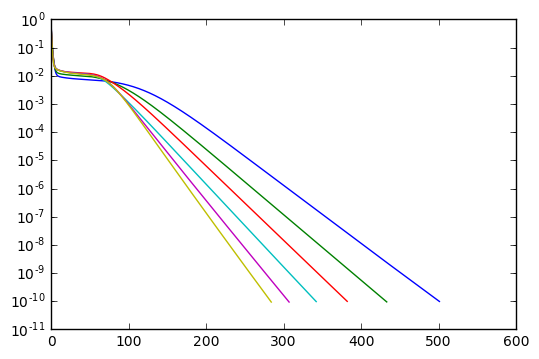

In [288]:
pathname = './SCM_erf2_ST_N100_macro_twononzeroLambda_jikken2_commonInit/'

for filename in glob.glob(pathname + '*/*.npz'):
    npz = np.load(filename)
    lam1, p1, lam2, p2 = map(float, re.match('.*lam1=(.*),p1=(.*),lam2=(.*),p2=(.*)/.*', filename).groups())
    opL = npz['opL']
    if opL[-1] != opL[-1] or opL[-1] == np.inf or opL[-1] == -np.inf:
        print('!!', filename, ':diverged')
        continue
    plt.plot(np.arange(len(opL)), opL)
    print(lam1,p1,lam2,p2, len(opL))
plt.yscale('log')
# plt.ylim(1e-4, 1e0)
# plt.xscale('log')
# plt.xlim(0, 100)
plt.show()

## 1次，2次を固定して，3次モーメントをいじっていこう

In [46]:
def two_nonzero_with_moment123(n, m1, m2, m3):
    # [l1, ..., l1 (割合p1), l2, ..., l2 (割合p2)]
    '''
    以下を解く：
    p1 + p2 = 1
    l1 * p1 + l2 * p2 = m1
    l1**2 * p1 + l2**2 * p2 = m2
    l1**3 * p1 + l2**3 * p2 = m3
    '''
    xs = np.linspace(0, 10.0, 100000, endpoint=False)
    ys = (m3 - m1*xs**2)/(m2-xs**2)
    zs = (m3 - m1*ys**2)/(m2-ys**2)
    best_idx = np.argmin(np.abs(xs - zs))
    lam1 = xs[best_idx]
    lam2 = ys[best_idx]
    p1 = (lam2 - m1)/(lam2 - lam1)
    p2 = (lam1 - m1)/(lam1 - lam2)
    print('query: m1={}, m2={}, m3={}'.format(m1, m2, m3))
    print('solution: p1={:.6f}, p2={:.6f}, lam1={:.6f}, lam2={:.6f}'.format(p1, p2, lam1, lam2))
    cm1 = lam1*p1 + lam2*p2
    cm2 = lam1**2*p1 + lam2**2*p2
    cm3 = lam1**3*p1 + lam2**3*p2
    print('check: m1={}, m2={}, m3={}'.format(cm1, cm2, cm3))
    print()
    num1= int(round(n * p1))
    num2 = n - num1
    return num1, num2, lam1, lam2

two_nonzero_with_moment123(N, 1, 1.25, 1.6) # 大きい方のラムダが多数派になる
two_nonzero_with_moment123(N, 1, 1.25, 1.75) # 0.5と1.5が半分ずつ
two_nonzero_with_moment123(N, 1, 1.25, 2) # 小さい方のラムダが多数派になる
two_nonzero_with_moment123(N, 1, 1.25, 2.5)

query: m1=1, m2=1.25, m3=1.6
solution: p1=0.757239, p2=0.242761, lam1=1.283100, lam2=0.116932
check: m1=1.0, m2=1.2499964614216366, m3=1.5999995862258378

query: m1=1, m2=1.25, m3=1.75
solution: p1=0.500000, p2=0.500000, lam1=0.500000, lam2=1.500000
check: m1=1.0, m2=1.25, m3=1.75

query: m1=1, m2=1.25, m3=2
solution: p1=0.146448, p2=0.853552, lam1=2.207100, lam2=0.792892
check: m1=1.0, m2=1.2500006620568165, m3=2.000000524939227

query: m1=1, m2=1.25, m3=2.5
solution: p1=0.025659, p2=0.974341, lam1=4.081100, lam2=0.918860
check: m1=1.0, m2=1.2500019926483839, m3=2.5000018309638983



(3, 97, 4.0811, 0.9188595006171875)

In [99]:
# 色々な固有値分布でオーパラの数値解をたくさん保存するよ その5 [lam1, ..., lam1, lam2, ..., lam2] (lam1の割合は p1, lam2の割合はp2)
# mu1 = 1, mu2 = 1.25 を固定して， mu3 を変えていく． 
# 初期値を共通化！ ⇨ 初期値に依存したプラトーの出方とかのばらつきを考えずに比較可能に．
# 乱数のタネを一時的に固定して重みを生成するよ
randstate = np.random.get_state()
np.random.seed(42)
ms = MLP(ls=[N,2,1], nobias=True, act=func_erf2, opt=None)
mt = MLP(ls=[N,2,1], nobias=True, act=func_erf2, opt=None)
np.random.set_state(randstate)
ms.l[1].W.data = np.array([[1, 1]], dtype=np.float32) 
mt.l[1].W.data = np.array([[1, 1]], dtype=np.float32) 

for mu in [[1.0, 1.25, mu3] for mu3 in [1.725, 1.775, 1.825, 1.875, 1.925, 1.975, 2.025, 2.075, 2.125, 2.175, 2.225, 2.275, 2.325, 2.375, 2.425, 2.475]]:
    for i in range(1):
        mu1, mu2, mu3 = mu
        num1, num2, lam1, lam2 = two_nonzero_with_moment123(N, mu1, mu2, mu3)
        lambdas = np.sort(np.array([lam1] * num1 + [lam2] * num2))

        nb_iter = 10000
        eta = 1.0
        substep = 10  # 数値解法が乱れるので・・・（ルンゲクッタでも・・・）
        nrslt = calc_opd_highorder(N, nb_iter, lambdas, eta, mdl=ms, mdl_t=mt, goal_loss=1e-10, ignore_etasq=[True, True], substep=substep)

        pathname = './three-layer_committee_general_Sigma_results/SCM_erf2_ST_N100_macro_twononzeroLambda_jikken3_commonInit/mu1={},mu2={},mu3={}'.format(mu1, mu2, mu3)
        os.makedirs(pathname, exist_ok=True)
        np.savez(pathname+'/{}.npz'.format(i),
                 opL=nrslt['opL'], opQRT=nrslt['opQRT'],
                 mdl0=nrslt['mdl0'], mdl_t=nrslt['mdl_t'])

        plot_macro_dynamics(nrslt['opL'], nrslt['opQRT'][:,0,:,:], N=N)
        plt.savefig(pathname+'/{}.png'.format(i))
        plt.close()

query: m1=1.0, m2=1.25, m3=1.725
solution: p1=0.549743, p2=0.450257, lam1=1.452500, lam2=0.447518
check: m1=1.0, m2=1.2499981826244357, m3=1.7249991866920342

nQRT: [[[ 0.79783241 -0.13650283  0.08510195 -0.02324425]
  [-0.13650283  0.8426909   0.13623986  0.01738079]
  [ 0.08510195  0.13623986  1.14791614  0.03479817]
  [-0.02324425  0.01738079  0.03479817  0.90843212]]

 [[ 0.97813046 -0.18181768  0.122993   -0.03940227]
  [-0.18181768  1.01553338  0.18551597  0.04620276]
  [ 0.122993    0.18551597  1.4181268   0.04702579]
  [-0.03940227  0.04620276  0.04702579  1.20326677]]]
nABC: [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
sqrt(nT4/nT2):  [[1.40011645 1.43043207]
 [1.43043207 1.4239457 ]]
nT2/nT1:  [[1.23539234 1.35138684]
 [1.35138684 1.32455331]]
poly deg: 2
nb_iter: 10000
query: m1=1.0, m2=1.25, m3=1.775
solution: p1=0.450241, p2=0.549759, lam1=1.552500, lam2=0.547514
check: m1=0.9999999999999999, m2=1.249998653314731, m3=1.7749992626712987

nQRT: [[[ 0.8079722 

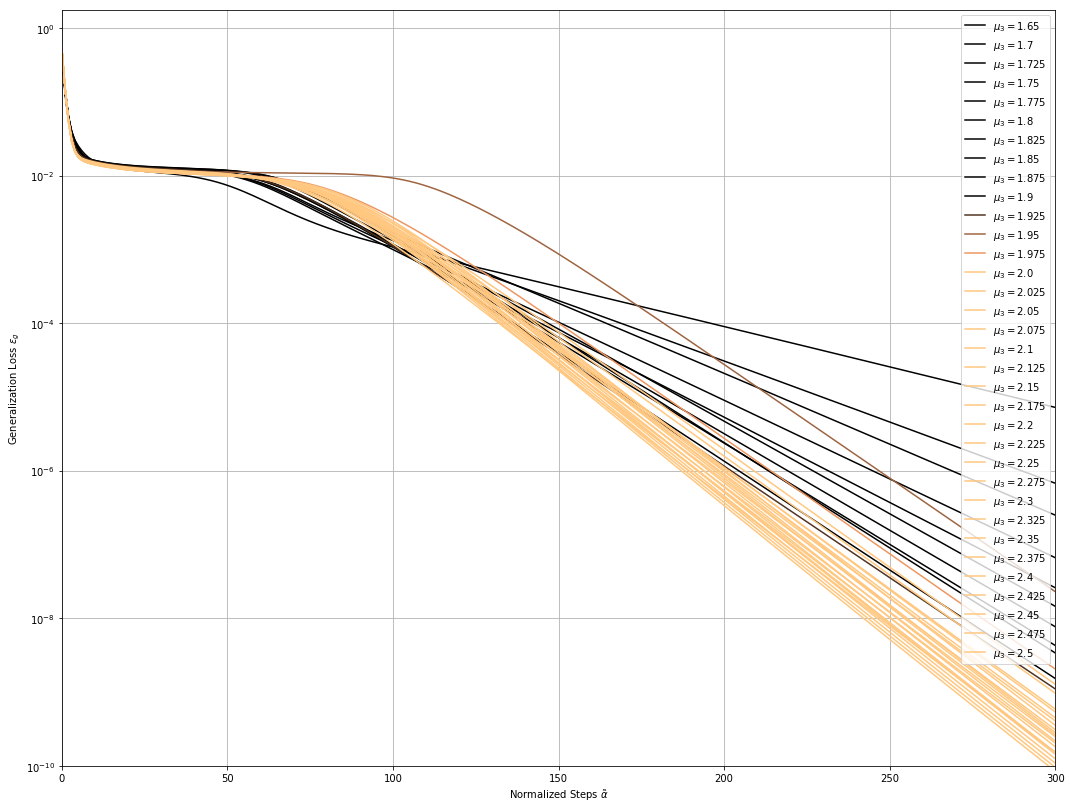

In [30]:
pathname = './three-layer_committee_general_Sigma_results/SCM_erf2_ST_N100_macro_twononzeroLambda_jikken3_commonInit/'
plt.figure(figsize=(20,15))
plt.subplots_adjust(bottom=0.18, left=0.21)
for filename in sorted(glob.glob(pathname + '*/*.npz')):
    npz = np.load(filename)
    re_match = re.match('.*mu1=(.*),mu2=(.*),mu3=(.*)/.*', filename)
    if re_match is None: continue
    mu1, mu2, mu3 = map(float, re_match.groups())
    if True: # 1.9 <= mu3 <= 2.0:
        opL = npz['opL']
        if opL[-1] != opL[-1] or opL[-1] == np.inf or opL[-1] == -np.inf:
            print('!!', filename, ':diverged')
            continue
        plt.plot(np.arange(len(opL)), opL, c=cm.copper((mu3 - 1.9)/0.1), label='$\\mu_3={}$'.format(mu3))
        # print(lam1,p1,lam2,p2, len(opL))
plt.yscale('log')
# plt.ylim(1e-4, 1e0)
# plt.xscale('log')
plt.xlim(0, 300)
plt.xlabel('Normalized Steps $\\tilde{\\alpha}$')
plt.ylabel('Generalization Loss $\\varepsilon_g$')
plt.ylim(1e-10, None)
plt.grid()
plt.legend(fontsize=10, loc='best')
# plt.savefig('./figures/dynamics_with_various_mu3.pdf', bbox_inches='tight', pad_inches=0) # For Figure
plt.show()

# え，え，どういうこと・・・・？？？？？？？？？ なんで mu3 = 1.95 だけイレギュラーなの？？？？？？

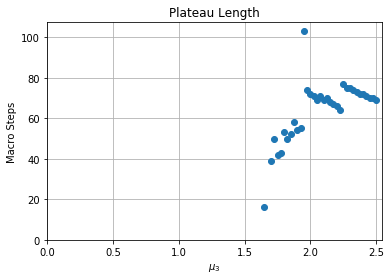

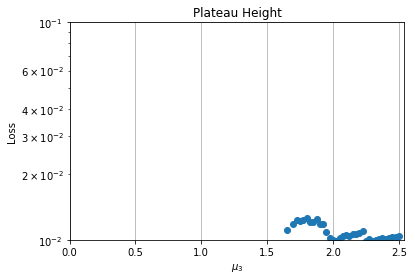

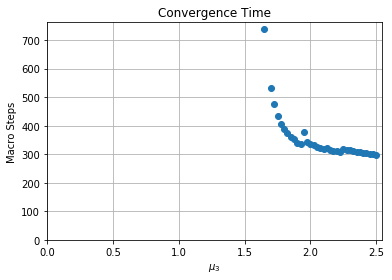

In [26]:
# プラトーの長さを定量しておこう．
m3_list, h_list, d_list, t_list = [], [], [], []
pathname = './three-layer_committee_general_Sigma_results/SCM_erf2_ST_N100_macro_twononzeroLambda_jikken3_commonInit/'

for filename in glob.glob(pathname + '*/*.npz'):
    npz = np.load(filename)
    re_match = re.match('.*mu1=(.*),mu2=(.*),mu3=(.*)/.*', filename)
    if re_match is None: continue
    mu1, mu2, mu3 = map(float, re_match.groups())
    if True:
        lossinfo = analyze_loss_curve(npz['opL'])
        if lossinfo['converge_time'] < np.inf: # 収束している場合
            if len(lossinfo['plateau_time_info']) > 2: # プラトーには高々一度しか入っていないことを確認
                print('プラトーに二回以上入っているようです:', lossinfo['plateau_time_info'])
            if len(lossinfo['plateau_time_info']) > 0:
                plateau_macrostep = lossinfo['plateau_time_info'][1] - lossinfo['plateau_time_info'][0]
                plateau_logheight = lossinfo['plateau_logheight_info'][0]
            else:
                plateau_macrostep = 0
                plateau_logheight = np.nan
            # (マクロ1ステップは， ミクロNステップ)
            m3_list.append(mu3)
            d_list.append(plateau_macrostep)
            h_list.append(plateau_logheight)
            t_list.append(lossinfo['converge_time'])

# plt.figure(figsize=(16,4))
plt.figure(figsize=(6,4))
# plt.subplot(131)
plt.plot(m3_list, d_list, linestyle='', marker='.', markersize=12)
plt.title('Plateau Length');
plt.xlim(0, None); plt.ylim(0, None)
plt.grid()
plt.xlabel('$\\mu_3$'); plt.ylabel('Macro Steps')
# plt.savefig('figures/pl_with_various_mu2.pdf', bbox_inches='tight', pad_inches=0)
plt.show()
# plt.subplot(132)
plt.plot(m3_list, np.exp(h_list), linestyle='', marker='.', markersize=12)
plt.yscale('log')
plt.xlim(0, None)
plt.ylim(1e-2, 1e-1)
plt.title('Plateau Height')
plt.grid()
plt.xlabel('$\\mu_3$'); plt.ylabel('Loss')
# plt.savefig('figures/ph_with_various_mu2.pdf', bbox_inches='tight', pad_inches=0)
plt.show()
# plt.subplot(133)
plt.plot(m3_list, t_list, linestyle='', marker='.', markersize=12)
plt.title('Convergence Time');
plt.xlim(0, None); plt.ylim(0, None)
plt.grid()
plt.xlabel('$\\mu_3$'); plt.ylabel('Macro Steps')
# plt.savefig('figures/ct_with_various_mu2.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

# ここからは，reluの場合を見てみよう．まずは，[0,...,0,lam,..,lam]の場合から．

In [292]:
# 色々な固有値分布でオーパラの数値解をたくさん保存するよ その2 [0, ..., 0, lam, ..., lam] (lamの割合は p)              の，  relu  バージョン
# ただし，I4が計算できないため，学習係数は無限小とします．（ignore_etasqをオンにすることに対応．）

# 初期値を共通化！ ⇨ 初期値に依存したプラトーの出方とかのばらつきを考えずに比較可能に．
# 乱数のタネを一時的に固定して重みを生成するよ
N = 100
randstate = np.random.get_state()
np.random.seed(42)
ms = MLP(ls=[N,2,1], nobias=True, act=F.relu, opt=None)
mt = MLP(ls=[N,2,1], nobias=True, act=F.relu, opt=None)
np.random.set_state(randstate)
ms.l[1].W.data = np.array([[1, 1]], dtype=np.float32) 
mt.l[1].W.data = np.array([[1, 1]], dtype=np.float32) 

for lam in [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]:
    for p in [1.0, 0.9, 0.8, 0.7, 0.6, 0.5]:
        for i in range(1):
            num = int(N * p)
            lambdas = np.array([0.0] * (N - num) + [lam] * num)
            nb_iter = 10000
            eta = 1.0
            nrslt = calc_opd(N, nb_iter, lambdas, eta, mdl=ms, mdl_t=mt, goal_loss=1e-10, act='relu', ignore_etasq=[True,True])
            
            pathname = './SCM_relu_ST_N100_macro_onenonzeroLambda_commonInit/lam={},p={}'.format(lam, p)
            os.makedirs(pathname, exist_ok=True)
            np.savez(pathname+'/{}.npz'.format(i),
                     opL=nrslt['opL'], opQRT=nrslt['opQRT'],
                     mdl0=nrslt['mdl0'], mdl_t=nrslt['mdl_t'])
            
            plot_macro_dynamics(nrslt['opL'], nrslt['opQRT'], N=N)
            plt.savefig(pathname+'/{}.png'.format(i))
            plt.close()

nQRT: [[ 0.8273063  -0.1192889   0.05954009 -0.00732629]
 [-0.1192889   0.90088715  0.11283072 -0.02027471]
 [ 0.05954009  0.11283072  1.17370965  0.02937043]
 [-0.00732629 -0.02027471  0.02937043  0.80423793]]
nABC: [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
sqrt(nT4/nT2):  [[1. 1.]
 [1. 1.]]
nT2/nT1:  [[1. 1.]
 [1. 1.]]
QRTcoef:  [1.         1.17370965]
nb_iter: 10000
nQRT: [[ 0.76018373 -0.12734675  0.04005091 -0.02431084]
 [-0.12734675  0.83298077  0.10203625 -0.0103973 ]
 [ 0.04005091  0.10203625  0.950565    0.00585364]
 [-0.02431084 -0.0103973   0.00585364  0.75901313]]
nABC: [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
sqrt(nT4/nT2):  [[1. 1.]
 [1. 1.]]
nT2/nT1:  [[1. 1.]
 [1. 1.]]
QRTcoef:  [1.       0.950565]
nb_iter: 10000
nQRT: [[ 6.46323288e-01 -6.66840208e-02  3.76004798e-02  3.54307969e-03]
 [-6.66840208e-02  7.01781072e-01  8.96127242e-02 -3.92111132e-04]
 [ 3.76004798e-02  8.96127242e-02  8.33066939e-01  1.17198879e-02]
 [ 3.54307969e-

プラトーに二回以上入っているようです: [38, 178, 535, 536]
プラトーに二回以上入っているようです: [36, 188, 585, 586]
プラトーに二回以上入っているようです: [43, 110, 850, 851]
プラトーに二回以上入っているようです: [41, 144, 909, 910]
プラトーに二回以上入っているようです: [19, 89, 330, 331]
プラトーに二回以上入っているようです: [10, 37, 258, 259]


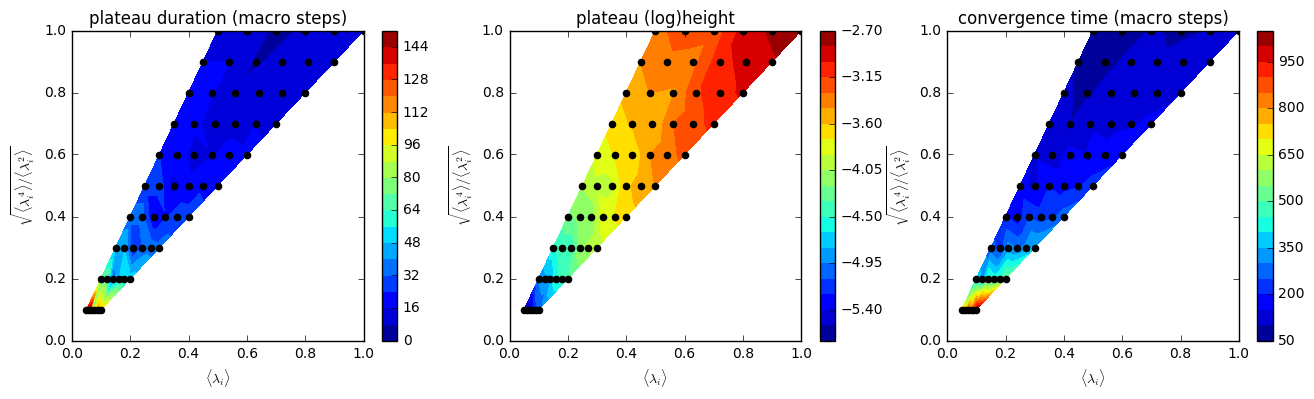

In [301]:
m1_list, sqm4m2_list, h_list, d_list, t_list = [], [], [], [], []
pathname = './SCM_relu_ST_N100_macro_onenonzeroLambda_commonInit/'

for filename in glob.glob(pathname + '*/*.npz'):
    npz = np.load(filename)
    lam, p = map(float, re.match('.*lam=(.*),p=(.*)/.*', filename).groups())
    # print(npz['opL'].shape) # (1001,) この 1 はミクロでの N(=100) step に相当するので注意．
    lossinfo = analyze_loss_curve(npz['opL'])
    if lossinfo['converge_time'] < np.inf: # 収束している場合
        if len(lossinfo['plateau_time_info']) > 2: # プラトーには高々一度しか入っていないことを確認
            print('プラトーに二回以上入っているようです:', lossinfo['plateau_time_info'])
        if len(lossinfo['plateau_time_info']) > 0:
            plateau_macrostep = lossinfo['plateau_time_info'][1] - lossinfo['plateau_time_info'][0]
            plateau_logheight = lossinfo['plateau_logheight_info'][0]
        else:
            plateau_macrostep = 0
            plateau_logheight = np.nan
        # (マクロ1ステップは， ミクロNステップ)
        m1_list.append(lam * p)
        sqm4m2_list.append(lam)
        d_list.append(plateau_macrostep)
        h_list.append(plateau_logheight)
        t_list.append(lossinfo['converge_time'])

m1_list = np.array(m1_list)        
sqm4m2_list = np.array(sqm4m2_list)        
d_list = np.array(d_list)        
h_list = np.array(h_list)        
t_list = np.array(t_list)        
        
plt.figure(figsize=(16,4))
plt.subplot(131)
plt.tricontourf(m1_list, sqm4m2_list, d_list, 20)
plt.xlim(0, 1); plt.ylim(0, 1); plt.title('plateau duration (macro steps)');
plt.xlabel('$\\langle\\lambda_i\\rangle$'); plt.ylabel('$\\sqrt{\\langle\\lambda_i^4\\rangle/\\langle\\lambda_i^2\\rangle}$')
ax = plt.gca()
plt.colorbar()
ax.scatter(m1_list, sqm4m2_list, color='k')
plt.subplot(132)
valid_idx = np.flatnonzero(h_list == h_list) # nan検出
plt.tricontourf(m1_list[valid_idx], sqm4m2_list[valid_idx], h_list[valid_idx], 20) # tricontourf に np.nan 投げると kernelが死ぬのを回避している
plt.xlim(0, 1); plt.ylim(0, 1); plt.title('plateau (log)height')
plt.xlabel('$\\langle\\lambda_i\\rangle$'); plt.ylabel('$\\sqrt{\\langle\\lambda_i^4\\rangle/\\langle\\lambda_i^2\\rangle}$')
ax = plt.gca()
plt.colorbar()
ax.scatter(m1_list, sqm4m2_list, color='k')
plt.subplot(133)
plt.tricontourf(m1_list, sqm4m2_list, t_list, 20)
plt.xlim(0, 1); plt.ylim(0, 1); plt.title('convergence time (macro steps)');
plt.xlabel('$\\langle\\lambda_i\\rangle$'); plt.ylabel('$\\sqrt{\\langle\\lambda_i^4\\rangle/\\langle\\lambda_i^2\\rangle}$')
ax = plt.gca()
plt.colorbar()
ax.scatter(m1_list, sqm4m2_list, color='k')
plt.show()

プラトーに二回以上入っているようです: [41, 144, 909, 910]
プラトーに二回以上入っているようです: [10, 37, 258, 259]


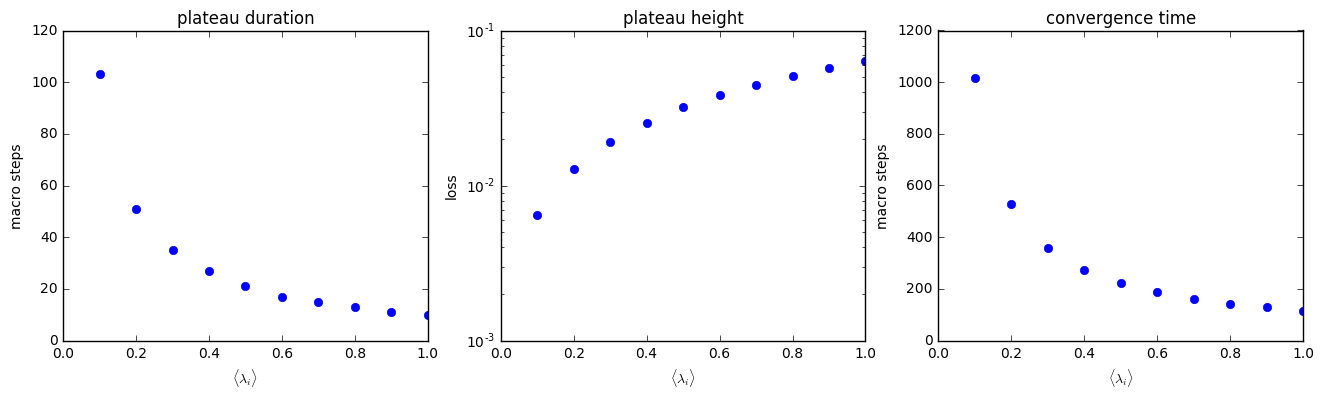

In [302]:
# 上図の対角線部分は p=1 部分，すなわち [lam, ..., lam] の固有値分布の部分なんだけど，
# その部分の結果だけをグラフにしてみるよ
m1_list, sqm4m2_list, h_list, d_list, t_list = [], [], [], [], []
pathname = './SCM_relu_ST_N100_macro_onenonzeroLambda_commonInit/'

for filename in glob.glob(pathname + '*/*.npz'):
    npz = np.load(filename)
    lam, p = map(float, re.match('.*lam=(.*),p=(.*)/.*', filename).groups())
    if p == 1:
        lossinfo = analyze_loss_curve(npz['opL'])
        if lossinfo['converge_time'] < np.inf: # 収束している場合
            if len(lossinfo['plateau_time_info']) > 2: # プラトーには高々一度しか入っていないことを確認
                print('プラトーに二回以上入っているようです:', lossinfo['plateau_time_info'])
            if len(lossinfo['plateau_time_info']) > 0:
                plateau_macrostep = lossinfo['plateau_time_info'][1] - lossinfo['plateau_time_info'][0]
                plateau_logheight = lossinfo['plateau_logheight_info'][0]
            else:
                plateau_macrostep = 0
                plateau_logheight = np.nan
            # (マクロ1ステップは， ミクロNステップ)
            m1_list.append(lam * p)
            sqm4m2_list.append(lam)
            d_list.append(plateau_macrostep)
            h_list.append(plateau_logheight)
            t_list.append(lossinfo['converge_time'])

plt.figure(figsize=(16,4))
plt.subplot(131)
plt.plot(m1_list, d_list, linestyle='', marker='.', markersize=12)
plt.title('plateau duration');
plt.xlim(0, 1); plt.ylim(0, None)
plt.xlabel('$\\langle\\lambda_i\\rangle$'); plt.ylabel('macro steps')
plt.subplot(132)
plt.plot(m1_list, np.exp(h_list), linestyle='', marker='.', markersize=12)
plt.yscale('log')
plt.xlim(0, 1)
plt.title('plateau height')
plt.xlabel('$\\langle\\lambda_i\\rangle$'); plt.ylabel('loss')
plt.subplot(133)
plt.plot(m1_list, t_list, linestyle='', marker='.', markersize=12)
plt.title('convergence time');
plt.xlim(0, 1); plt.ylim(0, None)
plt.xlabel('$\\langle\\lambda_i\\rangle$'); plt.ylabel('macro steps')
plt.show()

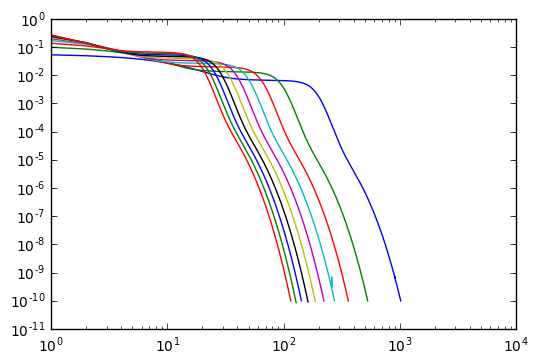

In [303]:
# 生の学習曲線も見ておこう 
pathname = './SCM_relu_ST_N100_macro_onenonzeroLambda_commonInit/'

for filename in glob.glob(pathname + '*/*.npz'):
    npz = np.load(filename)
    lam, p = map(float, re.match('.*lam=(.*),p=(.*)/.*', filename).groups())
    if p == 1:
        opL = npz['opL']
        if opL[-1] != opL[-1] or opL[-1] == np.inf or opL[-1] == -np.inf:
            print('!!', filename, ':diverged')
            continue
        plt.plot(np.arange(len(opL)), opL)
plt.yscale('log')
plt.xscale('log')
plt.show()

# 実データの mu1, mu2, mu3 を使った学習をやってみよう．

In [33]:
iris_lams = get_iris_lambdas()
mnist_lams = get_mnist_lambdas()

array([2.35354111e-02, 8.02401290e-02, 2.09402049e+00, 6.13768706e+01])

In [71]:
iris_lams

array([2.35354111e-02, 8.02401290e-02, 2.09402049e+00, 6.13768706e+01])

In [72]:
mnist_lams

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.46282807e-69, 8.76156680e-69, 1.25528522e-68,
       4.82738587e-68, 1.19882550e-67, 5.20177342e-67, 5.80535919e-65,
       1.47736379e-64, 2.11394992e-64, 3.32675014e-64, 2.81336810e-40,
       5.92367249e-40, 3.13161955e-39, 1.13756426e-38, 3.26230298e-38,
       7.58738706e-38, 1.81189435e-37, 3.45258223e-37, 1.06702849e-36,
       1.68960956e-36, 4.14010389e-36, 4.77849568e-36, 1.14027321e-35,
       2.46848584e-35, 1.01289363e-34, 1.76467761e-34, 2.19849094e-34,
       2.57701619e-34, 4.52063198e-34, 7.48811563e-34, 8.61715470e-34,
       1.47130302e-33, 2.21052689e-33, 2.58214235e-33, 2.79587814e-33,
       4.27393552e-33, 5.08863328e-33, 6.44712751e-33, 7.03764919e-33,
       9.33915084e-33, 1.06925800e-32, 1.21651338e-32, 1.67474691e-32,
       1.93357643e-32, 2.43148920e-32, 2.59097089e-32, 2.87122050e-32,
       2.99587605e-32, 3.40902394e-32, 3.98291068e-32, 4.31406009e-32,
      

In [73]:
iris_mu1 = np.mean(iris_lams)
iris_mu2 = np.mean(iris_lams**2)
iris_mu3 = np.mean(iris_lams**3)

In [74]:
two_nonzero_with_moment123(N, iris_mu1, iris_mu2, iris_mu3)

query: m1=15.89366666666667, m2=942.8780409511116, m3=57805.80872332835
solution: p1=0.749437, p2=0.250563, lam1=0.702200, lam2=61.331594
check: m1=15.89366666666667, m2=942.8774030684674, m3=57805.76960096881



(75, 25, 0.7022, 61.33159429428366)

In [75]:
mnist_mu1 = np.mean(mnist_lams)
mnist_mu2 = np.mean(mnist_lams**2)
mnist_mu3 = np.mean(mnist_lams**3)

In [76]:
two_nonzero_with_moment123(N, mnist_mu1, mnist_mu2, mnist_mu3)

query: m1=0.11200259182975345, m2=1.9497576238281433, m3=70.7849240928914
solution: p1=0.998529, p2=0.001471, lam1=0.058600, lam2=36.368329
check: m1=0.11200259182975345, m2=1.9487263846718699, m3=70.74741964790744



(100, 0, 0.058600000000000006, 36.36832906878807)

In [80]:
N = 100
# IRIS の mu1, mu2, mu3 から twoNonzeroLambda を生成し，それでマクロ計算．
for mu in [[iris_mu1, iris_mu2, iris_mu3]]:
    mu1, mu2, mu3 = mu
    num1, num2, lam1, lam2 = two_nonzero_with_moment123(N, mu1, mu2, mu3)
    lambdas = np.sort(np.array([lam1] * num1 + [lam2] * num2))
    
    for i in range(5):
        # 重み初期化．
        randstate = np.random.get_state()
        np.random.seed(i)
        ms = MLP(ls=[N,2,1], nobias=True, act=func_erf2, opt=None)
        mt = MLP(ls=[N,2,1], nobias=True, act=func_erf2, opt=None)
        np.random.set_state(randstate)
        ms.l[1].W.data = np.array([[1, 1]], dtype=np.float32) 
        mt.l[1].W.data = np.array([[1, 1]], dtype=np.float32) 
        
        nb_iter = 10000
        eta = 1.0
        substep = 100  # 数値解法が乱れるので・・・（ルンゲクッタでも・・・）
        nrslt = calc_opd_highorder(N, nb_iter, lambdas, eta, mdl=ms, mdl_t=mt, goal_loss=1e-10, ignore_etasq=[True, True], substep=substep)

        pathname = './three-layer_committee_general_Sigma_results/SCM_erf2_ST_N100_macro_twononzeroLambda_jikken4_commonInit/mu1={},mu2={},mu3={}'.format(mu1, mu2, mu3)
        os.makedirs(pathname, exist_ok=True)
        np.savez(pathname+'/{}.npz'.format(i),
                 opL=nrslt['opL'], opQRT=nrslt['opQRT'],
                 mdl0=nrslt['mdl0'], mdl_t=nrslt['mdl_t'])

        plot_macro_dynamics(nrslt['opL'], nrslt['opQRT'][:,0,:,:], N=N)
        plt.savefig(pathname+'/{}.png'.format(i))
        plt.close()

query: m1=15.89366666666667, m2=942.8780409511116, m3=57805.80872332835
solution: p1=0.749437, p2=0.250563, lam1=0.702200, lam2=61.331594
check: m1=15.89366666666667, m2=942.8774030684674, m3=57805.76960096881

nQRT: [[[ 1.43850653e+01  2.58331324e+00  2.48883508e+00  1.11534782e+00]
  [ 2.58331324e+00  1.73849014e+01 -7.38959611e+00  2.78437815e+00]
  [ 2.48883508e+00 -7.38959611e+00  1.94307311e+01  1.18677580e+00]
  [ 1.11534782e+00  2.78437815e+00  1.18677580e+00  1.96342287e+01]]

 [[ 8.48457482e+02  1.55023575e+02  1.53431137e+02  7.02588550e+01]
  [ 1.55023575e+02  1.03205691e+03 -4.52188292e+02  1.70257257e+02]
  [ 1.53431137e+02 -4.52188292e+02  1.16434296e+03  6.87914938e+01]
  [ 7.02588550e+01  1.70257257e+02  6.87914938e+01  1.18034933e+03]]]
nABC: [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
sqrt(nT4/nT2):  [[61.32324454 61.31096573]
 [61.31096573 61.3244186 ]]
nT2/nT1:  [[59.92275602 57.96502915]
 [57.96502915 60.11691876]]
poly deg: 2
nb_iter: 10000
nQRT:

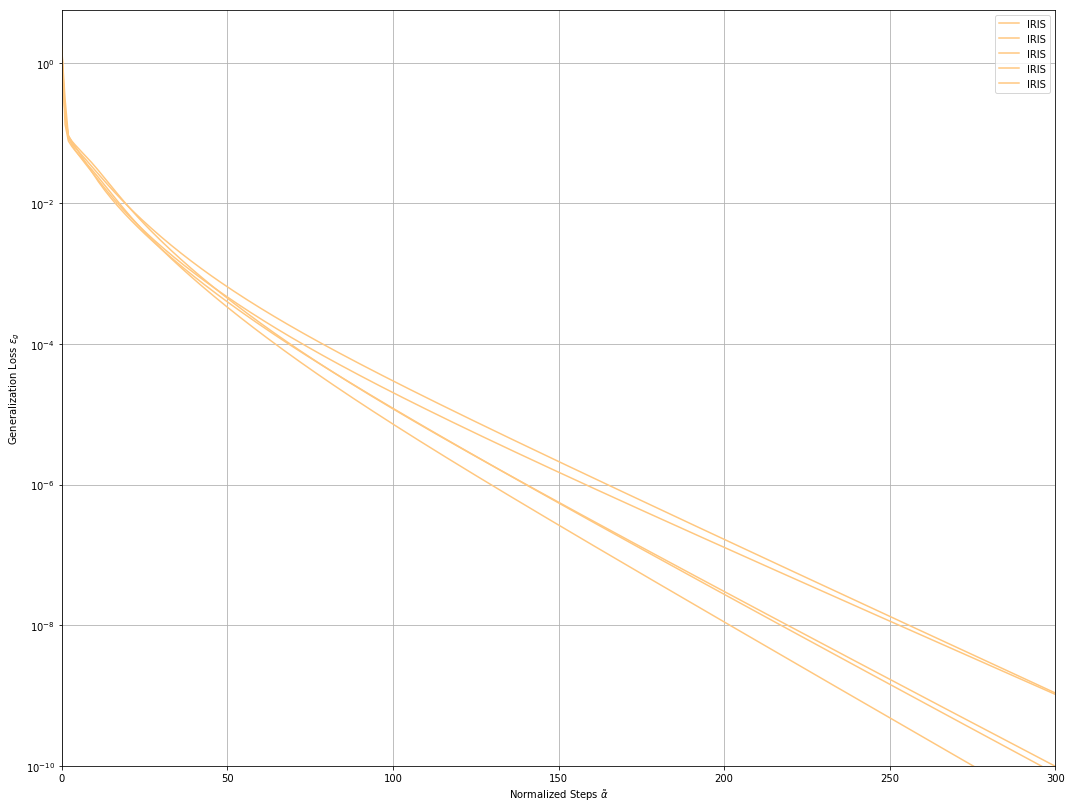

In [81]:
pathname = './three-layer_committee_general_Sigma_results/SCM_erf2_ST_N100_macro_twononzeroLambda_jikken4_commonInit/'
plt.figure(figsize=(20,15))
plt.subplots_adjust(bottom=0.18, left=0.21)
for filename in sorted(glob.glob(pathname + '*/*.npz')):
    npz = np.load(filename)
    re_match = re.match('.*mu1=(.*),mu2=(.*),mu3=(.*)/.*', filename)
    if re_match is None: continue
    mu1, mu2, mu3 = map(float, re_match.groups())
    if True: # 1.9 <= mu3 <= 2.0:
        opL = npz['opL']
        if opL[-1] != opL[-1] or opL[-1] == np.inf or opL[-1] == -np.inf:
            print('!!', filename, ':diverged')
            continue
        plt.plot(np.arange(len(opL)), opL, c=cm.copper((mu3 - 1.9)/0.1), label='IRIS')
        # print(lam1,p1,lam2,p2, len(opL))
plt.yscale('log')
# plt.ylim(1e-4, 1e0)
# plt.xscale('log')
plt.xlim(0, 300)
plt.xlabel('Normalized Steps $\\tilde{\\alpha}$')
plt.ylabel('Generalization Loss $\\varepsilon_g$')
plt.ylim(1e-10, None)
plt.grid()
plt.legend(fontsize=10, loc='best')
# plt.savefig('./figures/dynamics_with_various_mu3.pdf', bbox_inches='tight', pad_inches=0) # For Figure
plt.show()

In [82]:
N = 100
# IRIS の lambda1 ~ lambda4 をそのまま使ってマクロ計算．
for lams in [iris_lambdas]:
    lam1, lam2, lam3, lam4 = lams
    lambdas = np.sort(np.array([lam1] * (N//4) + [lam2] * (N//4)+ [lam3] * (N//4) + [lam4] * (N//4) ))
    
    for i in range(1):
        # 重み初期化．
        randstate = np.random.get_state()
        np.random.seed(i)
        ms = MLP(ls=[N,2,1], nobias=True, act=func_erf2, opt=None)
        mt = MLP(ls=[N,2,1], nobias=True, act=func_erf2, opt=None)
        np.random.set_state(randstate)
        ms.l[1].W.data = np.array([[1, 1]], dtype=np.float32) 
        mt.l[1].W.data = np.array([[1, 1]], dtype=np.float32) 
        
        nb_iter = 10000
        eta = 1.0
        substep = 100  # 数値解法が乱れるので・・・（ルンゲクッタでも・・・）
        nrslt = calc_opd_highorder(N, nb_iter, lambdas, eta, mdl=ms, mdl_t=mt, goal_loss=1e-10, ignore_etasq=[True, True], substep=substep)

        pathname = './three-layer_committee_general_Sigma_results/SCM_erf2_ST_N100_macro_twononzeroLambda_jikken5_commonInit'
        os.makedirs(pathname, exist_ok=True)
        np.savez(pathname+'/{}.npz'.format(i),
                 opL=nrslt['opL'], opQRT=nrslt['opQRT'],
                 mdl0=nrslt['mdl0'], mdl_t=nrslt['mdl_t'])

        plot_macro_dynamics(nrslt['opL'], nrslt['opQRT'][:,0,:,:], N=N)
        plt.savefig(pathname+'/{}.png'.format(i))
        plt.close()

nQRT: [[[ 1.41854139e+01  2.58732366e+00  2.54501626e+00  1.10604843e+00]
  [ 2.58732366e+00  1.73561960e+01 -7.43781033e+00  2.78102843e+00]
  [ 2.54501626e+00 -7.43781033e+00  1.95435184e+01  1.24264835e+00]
  [ 1.10604843e+00  2.78102843e+00  1.24264835e+00  1.95510839e+01]]

 [[ 8.49981374e+02  1.55324161e+02  1.53763235e+02  7.02976102e+01]
  [ 1.55324161e+02  1.03422738e+03 -4.52968846e+02  1.70503002e+02]
  [ 1.53763235e+02 -4.52968846e+02  1.16685385e+03  6.90983419e+01]
  [ 7.02976102e+01  1.70503002e+02  6.90983419e+01  1.18237962e+03]]

 [[ 5.21299004e+04  9.52671595e+03  9.43179486e+03  4.31977547e+03]
  [ 9.52671595e+03  6.34158247e+04 -2.77944239e+04  1.04649265e+04]
  [ 9.43179486e+03 -2.77944239e+04  7.15521085e+04  4.22612524e+03]
  [ 4.31977547e+03  1.04649265e+04  4.22612524e+03  7.25373478e+04]]

 [[ 3.19948813e+06  5.84706261e+05  5.78882040e+05  2.65145053e+05]
  [ 5.84706261e+05  3.89213562e+06 -1.70591930e+06  6.42304450e+05]
  [ 5.78882040e+05 -1.70591930e+06  

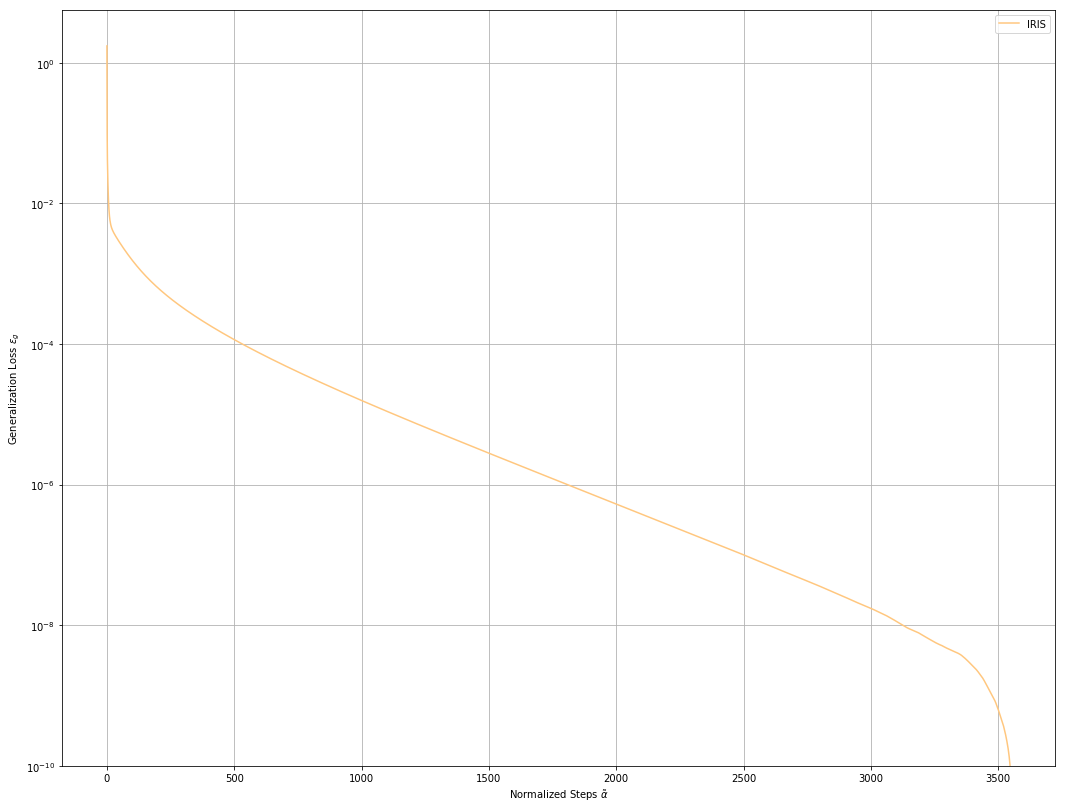

In [84]:
pathname = './three-layer_committee_general_Sigma_results/SCM_erf2_ST_N100_macro_twononzeroLambda_jikken5_commonInit/'
plt.figure(figsize=(20,15))
plt.subplots_adjust(bottom=0.18, left=0.21)
for filename in sorted(glob.glob(pathname + '*.npz')):
    npz = np.load(filename)
    # re_match = re.match('.*mu1=(.*),mu2=(.*),mu3=(.*)/.*', filename)
    if re_match is None: continue
    # mu1, mu2, mu3 = map(float, re_match.groups())
    if True: # 1.9 <= mu3 <= 2.0:
        opL = npz['opL']
        if opL[-1] != opL[-1] or opL[-1] == np.inf or opL[-1] == -np.inf:
            print('!!', filename, ':diverged')
            continue
        plt.plot(np.arange(len(opL)), opL, c=cm.copper((mu3 - 1.9)/0.1), label='IRIS')
        # print(lam1,p1,lam2,p2, len(opL))
plt.yscale('log')
# plt.ylim(1e-4, 1e0)
# plt.xscale('log')
# plt.xlim(0, 300)
plt.xlabel('Normalized Steps $\\tilde{\\alpha}$')
plt.ylabel('Generalization Loss $\\varepsilon_g$')
plt.ylim(1e-10, None)
plt.grid()
plt.legend(fontsize=10, loc='best')
# plt.savefig('./figures/dynamics_with_various_mu3.pdf', bbox_inches='tight', pad_inches=0) # For Figure
plt.show()

In [ ]:
N = 784
# MNIST の mu1, mu2, mu3 から twoNonzeroLambda を生成し，それでマクロ計算．
for mu in [[mnist_mu1, mnist_mu2, mnist_mu3]]:
    mu1, mu2, mu3 = mu
    num1, num2, lam1, lam2 = two_nonzero_with_moment123(N, mu1, mu2, mu3)
    lambdas = np.sort(np.array([lam1] * num1 + [lam2] * num2))
    
    for i in range(1):
        # 重み初期化．
        randstate = np.random.get_state()
        np.random.seed(i)
        ms = MLP(ls=[N,2,1], nobias=True, act=func_erf2, opt=None)
        mt = MLP(ls=[N,2,1], nobias=True, act=func_erf2, opt=None)
        np.random.set_state(randstate)
        ms.l[1].W.data = np.array([[1, 1]], dtype=np.float32) 
        mt.l[1].W.data = np.array([[1, 1]], dtype=np.float32) 
        
        nb_iter = 10000
        eta = 1.0
        substep = 100  # 数値解法が乱れるので・・・（ルンゲクッタでも・・・）
        nrslt = calc_opd_highorder(N, nb_iter, lambdas, eta, mdl=ms, mdl_t=mt, goal_loss=1e-10, ignore_etasq=[True, True], substep=substep)

        pathname = './three-layer_committee_general_Sigma_results/SCM_erf2_ST_N100_macro_twononzeroLambda_jikken6_commonInit/mu1={},mu2={},mu3={}'.format(mu1, mu2, mu3)
        os.makedirs(pathname, exist_ok=True)
        np.savez(pathname+'/{}.npz'.format(i),
                 opL=nrslt['opL'], opQRT=nrslt['opQRT'],
                 mdl0=nrslt['mdl0'], mdl_t=nrslt['mdl_t'])

        plot_macro_dynamics(nrslt['opL'], nrslt['opQRT'][:,0,:,:], N=N)
        plt.savefig(pathname+'/{}.png'.format(i))
        plt.close()

query: m1=0.11200259182975345, m2=1.9497576238281433, m3=70.7849240928914
solution: p1=0.998529, p2=0.001471, lam1=0.058600, lam2=36.368329
check: m1=0.11200259182975345, m2=1.9487263846718699, m3=70.74741964790744

nQRT: [[[ 1.42349794e-01 -9.57655760e-03  7.53545081e-02  5.35037817e-02]
  [-9.57655760e-03  5.31750232e-02 -1.85400291e-03 -3.30231081e-03]
  [ 7.53545081e-02 -1.85400291e-03  1.21220651e-01  4.74401531e-02]
  [ 5.35037817e-02 -3.30231081e-03  4.74401531e-02  8.68013784e-02]]

 [[ 3.03950633e+00 -1.79339837e-01  2.68171560e+00  1.88941494e+00]
  [-1.79339837e-01  1.36604542e-02 -1.58016284e-01 -1.11446636e-01]
  [ 2.68171560e+00 -1.58016284e-01  2.37184951e+00  1.66885120e+00]
  [ 1.88941494e+00 -1.11446636e-01  1.66885120e+00  1.17890958e+00]]]
nABC: [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
sqrt(nT4/nT2):  [[36.34311944 36.36733605]
 [36.36733605 36.31905851]]
nT2/nT1:  [[19.56638162 35.1780315 ]
 [35.1780315  13.58169192]]
poly deg: 2
nb_iter: 10000
